# Исследование данных медицинского центра

###### Описание проекта

Входные данные -  данные медицинского центра (информация о визитах пациентов в клинику).

Заказчик - медицинский центр.

Цель проекта - определить факторы, повлиявшие на изменение выручки и цены лечения в медицинской клинике:

* анализ изменения выручки в 2022г относительно 2021г
* выявление факторов изменения выручки

###### Описание данных:
- record_id - уникальный идентификатор строки данных;
- service_date - дата оказания медицинской услуги;
- service_name - наименование медицинской услуги;
- service_number - количество услуг;
- service_amount - сумма выплат (стоимость оказанных услуг в рублях);
- insured - уникальный идентификатор пациента;
- sex_id - пол пациента;
- age_for_service_date - возраст пациента

###### План работы: 
1. Считать, вывести, изучить информацию.
2. Произвести предобработку данных , преобразовать при необходимости.
3. Произвести исследовательский анализ данных, изучить основные стат. параметры, добавить нужные столбцы.
4. Проверить версии.
5. Сделать общий вывод по работе.

###### Оглавление:
1. [Изучение информации.](#dataset_info)
2. [Предобработка данных](#dataset_processing) 
3. [Исследовательский анализ данных.](#data_analysis)
3. [Анализ динамики выручки/цены лечения](#data_delta_measurement)   
4. [Факторы, повлиявшие на выручку/цену лечения](#suggestions)    
    4.1. [Влияние половозрастной структуры пациентов на выручку](#suggestion1)    
    4.2. [Влияние изменения структуры оказываемых услуг на выручку](#suggestion2)    
    4.3. [Влияние ценообразования по услугам на выручку](#suggestion3)      
5. [Общие выводы по кейсу](#results) 


<a id="dataset_info"></a> 
### Изучение информации. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import requests
import warnings
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings('ignore')

In [3]:
try:
    data = pd.read_excel('C:\\Users\\HP\\Desktop\\Yandex\\11_workshop\\data_test_task_2022.xlsx')
except:
    spreadsheet_id = '1ynNLmOVMxy0_8WrPRto-qaK5nKcO0sTu/edit#gid=314077092'
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=xlsx'.format(spreadsheet_id)
    r = requests.get(file_name)
    data = pd.read_excel(BytesIO(r.content)) 

In [4]:
data.head()

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.00,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284,1,490777,2.00,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134,1,490777,2.00,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.00,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.00,26


In [5]:
print(f'Количество строк {data.shape[0]}, количество столбцов {data.shape[1]}') 

Количество строк 85369, количество столбцов 8


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85369 entries, 0 to 85368
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   record_id             85369 non-null  int64  
 1   service_date          85369 non-null  object 
 2   service_name          85369 non-null  object 
 3   service_amount        85369 non-null  int64  
 4   service_number        85369 non-null  int64  
 5   insured               85369 non-null  int64  
 6   sex_id                85348 non-null  float64
 7   age_for_service_date  85369 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 5.2+ MB


Видим, что в столбце sex_id небольшое количество пропусков, тип столбца  service_date нужно заменить на datetime (формат даты), значения в столбце sex_id лучше заменить на категориальные значения.

<a id="dataset_processing"></a> 
### Предобработка данных. 

Посмотрим на пропуски.

In [7]:
data.isna().sum()

record_id                0
service_date             0
service_name             0
service_amount           0
service_number           0
insured                  0
sex_id                  21
age_for_service_date     0
dtype: int64

Проверим, можно ли подставить значение в столбец sex_id в зависимости от insured (уникальный идентификатор пациента), т.к. предполагаем, что есть ситуации, когда у одного пациента где-то проставлен пол, а где-то нет.

In [8]:
for i in data.loc[data['sex_id'].isna()]['insured'].unique():
    data.loc[(data['insured'] == i) & (data['sex_id'].isna()), 'sex_id'] =\
        data.loc[(data['sex_id'] == i) & (data['sex_id'].notna()), 'insured'] 

In [9]:
data['sex_id'].isna().sum()

21

Значения не подставились. Попробуем по обследованиям/назначениям (service_name) определить пол.

In [10]:
data[data['sex_id'].isna()]

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
4411,30489299203,2021-03-18,Прием первичный,1470,1,512590,NaN,26
4412,30489299303,2021-03-27,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,512590,NaN,26
4413,30489299403,2021-03-27,Общий анализ мочи,431,1,512590,NaN,26
4414,30489299503,2021-03-27,Альфа-амилаза панкреатическая,287,1,512590,NaN,26
4415,30489299603,2021-03-27,АЛТ (аланинаминотрансфераза),278,1,512590,NaN,26
4416,30489299703,2021-03-27,АСТ (аспартатаминотрансфераза),242,1,512590,NaN,26
4417,30489299803,2021-03-27,Билирубин общий,287,1,512590,NaN,26
4418,30489299903,2021-03-27,ГГТ (гамма - глютамилтрансфераза),287,1,512590,NaN,26
4419,30489300003,2021-03-27,Глюкоза крови,273,1,512590,NaN,26
4420,30489300103,2021-03-27,Фосфотаза щелочная,287,1,512590,NaN,26


service_name можно отнести к обоим полам. 


In [11]:
# посмотрим на долю пропусков в столбце пол
sex_id_isna = data['sex_id'].isna().sum() / len(data['record_id'])
print(f'Доля пропусков в столбце sex_id составляет {sex_id_isna:.4%}.')

Доля пропусков в столбце sex_id составляет 0.0246%.


In [12]:
data = data.dropna(subset=['sex_id']).reset_index(drop=True) # удалим строки, в которых отсутствует значение в столбце sex_id

Попробуем по наименованиям услуг определить пол.

In [13]:
data.query('sex_id == 2').head(15)

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date
0,30268157003,2021-01-24,Прием первичный,1470,1,490777,2.00,26
1,30268157103,2021-01-24,"Взятие материала на посев, цитологическое исследование ( риноцитограмма)",284,1,490777,2.00,26
2,30268157203,2021-01-24,"Посев отдел, дыхательных путей - слизистая зева с определением чувствительности к антибиотикам",1134,1,490777,2.00,26
3,30268157303,2021-01-24,"Общий анализ крови (лейкоцитарная форм,, СОЭ)",693,1,490777,2.00,26
4,30268157403,2021-01-24,Ревматоидный фактор,420,1,490777,2.00,26
5,30268157503,2021-01-24,С-реактивный белок,420,1,490777,2.00,26
6,30268157603,2021-01-24,Взятие крови из периферической вены,158,1,490777,2.00,26
7,30268157703,2021-01-26,Прием первичный,1470,1,490777,2.00,26
8,30268157803,2021-01-26,Магнитотерапия (1 сеанс),1040,1,490777,2.00,26
9,30268157903,2021-01-26,УВЧ-терапия (1 сеанс) (1 поле),1040,1,490777,2.00,26


Пол 2 - это женщины судя по наименованиям обследований (взятие мазка, обработка вульвы). Заменим категории пола на мужской/женский. 

In [14]:
data = data.replace({'sex_id' : { 1.0 :'мужчина' , 2.0 :'женщина'}})

In [15]:
# проверим, что не встречаются записи с различными значениями пола для одного пациента:
check_sex = data.groupby(['insured']).agg({'sex_id': 'nunique'}).rename(columns = {'sex_id': 'values_sex'})\
            .sort_values(by='values_sex', ascending = False).head()
check_sex     

,values_sex
insured,
125073,1
822712,1
822718,1
822717,1
822716,1


Убедились, что случаи, когда у одного пациента есть отнесение к разному полу, отсутствуют.

In [16]:
# изменим тип данных в столбце service_date
data['service_date'] = pd.to_datetime(data['service_date'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85348 entries, 0 to 85347
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   record_id             85348 non-null  int64         
 1   service_date          85348 non-null  datetime64[ns]
 2   service_name          85348 non-null  object        
 3   service_amount        85348 non-null  int64         
 4   service_number        85348 non-null  int64         
 5   insured               85348 non-null  int64         
 6   sex_id                85348 non-null  object        
 7   age_for_service_date  85348 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 5.2+ MB


Пропусков больше нет, тип данных корректный. Проверим на дубликаты (явные и неявные).

In [18]:
data.duplicated().sum() # По строкам явных дубликатов нет

0

In [19]:
#дубликатов нет - этому может способствовать поле record_id. Проверим, есть ли повторы, если сверить совокупность полей 
#без record_id.
data[['service_date', 'service_name','service_amount','service_number','insured','sex_id','age_for_service_date', \
          ]].duplicated().sum()

1348

In [20]:
# число записей не превышает 1,5% от выборки, предлагаю их удалить:
data = data.drop_duplicates(subset=['service_date', 'service_name','service_amount','service_number','insured', \
           'sex_id','age_for_service_date'], keep='first')

In [21]:
sorted(data['service_name'].unique()) #Проверим данные в столбце

['(1 E)Аллергопанель IgE (Молоко коровье, Молоко козье, Молоко овечье,Сыр, Творог,Сметана, Йогурт, Кефир )',
 '(2 E)Аллергопанель IgE (Пшеничная мука, Ржаная мука, Рис, Гречка, Овес, Перловка, Пшено, Ячменнная крупа )',
 '(3 E)Аллергопанель IgE (Фасоль (бобы), Горох, Чечевица (смесь), Кукуруза, Дрожжи пекарские, Белок куриного яйца, Желток куриного яйца, Яйцо перепелиное)',
 '(4 E)Аллергопанель IgE (Говядина, Телятина, Свинина, Баранина, Курица, Индейка, Утка, Гусь)',
 '(Б1 (11))Аллергопанель IgE шерсть кошки, шерсть собаки, шерсть овцы, клещ D,pteroniss, клещ D.farina, пыль домашняя, перо подушки, библиотечная пыль)',
 '17-OH - гидроксипрогестерон',
 '25-OH витамин D (25-гидроксихолекальциферол)',
 'Ascaris IgG',
 'Bordetella (pertusis) IgA',
 'Bordetella (pertusis) IgG',
 'Bordetella (pertusis) IgM',
 'Bordetella pertussis (Слюна)',
 'Bordetella pertussis (Соскоб)',
 'CMV (цитомегаловирус) (Кровь)',
 'CMV (цитомегаловирус) (Слюна)',
 'CMV (цитомегаловирус) (Соскоб)',
 'Candida albica

In [22]:
# скорректируем, где возможно, наименования процедур,приведем в порядок символы
data['service_name'] = data['service_name'].str.replace(' ,', '').str.replace(',', '').str.replace('(', '')\
.str.replace(')', '').str.strip().str.lower()  

In [23]:
# заменим некорректные названия
service = {
    'исследование глазного дна щелевой лампой офтальмоскопия':'исследование глазного дна щелевой лампой',
    'микроальбумин в моче разовая моча': 'микроальбумин в моче',
    'обработка вульвы лекарственными препаратами': 'обработка вульвы',
    'обработка шейки матки лекарственными препаратами': 'обработка шейки матки',
    'перевязка гнойных ран более 4смкв.': 'перевязка гнойных ран более 4 кв.см.',
    'перевязка гнойных ран менее 4 квсм.':'перевязка гнойных ран менее 4 кв.см.',
    'перевязка гнойных ран менее 4смкв.':'перевязка гнойных ран менее 4 кв.см.',
    'перевязка чистая более 4 смкв.':'перевязка чистая более 4 кв.см.',
    'перевязка чистая менее 4 квсм.':'перевязка чистая менее 4 кв.см.',
    'перевязка чистая менее 4 смкв.':'перевязка чистая менее 4 кв.см.',
    'прием врача эндокринолога руководителя направления блох сп':'прием врача эндокринолога руководителя направления блох с.п',
    'прием трапевта первичный':'прием терапевта первичный',
    'удаление серной пробки  за одно ухо':'удаление серных пробок за ухо',
    'трапевт': 'терапевт'
     }
for key, value in service.items():
    data['service_name'] = data['service_name'].str.replace(key, value) 

In [24]:
# выведем в отдельные столбцы значение года и значение месяца (с учетом года):
data['service_year'] = data['service_date'].dt.year
data['service_month'] = data['service_date'].dt.month
data['service_period']= data['service_date'].dt.strftime('%Y-%m')

In [25]:
# оценим частоту упоминания различных мед процедур:
data.pivot_table(index=['service_name'], columns =['service_year'], values='service_number', aggfunc=('count')) \
                                       .sort_values(by=2021, ascending = False)

service_year,2021,2022
service_name,,
прием первичный,5109.00,NaN
прием повторный,4165.00,NaN
взятие крови из периферической вены,2184.00,2022.00
общий анализ крови лейкоцитарная форм соэ,1671.00,1517.00
магнитотерапия 1 сеанс,1389.00,1449.00
общий анализ мочи,838.00,711.00
взятие мазка,665.00,894.00
лазеротерапия 1 сеанс,657.00,656.00
интерференционные токи 1 сеанс 4 поля,610.00,585.00


Видим, что в 2022г первичный и вторичный приемы разделены по специалистам. Скорректируем названия для возможности сравнения по годам.

In [26]:
def appoint(col):
    for name in col:
        if 'первичный' in col:
            return 'первичный приём'
        elif 'повторный' in col:
            return 'повторный приём'
        else:
            return col

In [27]:
data['service_name']=data['service_name'].apply(appoint)

In [28]:
data['service_name'].unique()

array(['первичный приём',
       'взятие материала на посев цитологическое исследование  риноцитограмма',
       'посев отдел дыхательных путей - слизистая зева с определением чувствительности к антибиотикам',
       'общий анализ крови лейкоцитарная форм соэ', 'ревматоидный фактор',
       'с-реактивный белок', 'взятие крови из периферической вены',
       'магнитотерапия 1 сеанс', 'увч-терапия 1 сеанс 1 поле',
       'повторный приём', 'смазывание глотки лекарственными формами',
       'взятие мазка', 'обработка вульвы', 'обработка шейки матки',
       'гинекологический мазок', 'общий анализ мочи', 'креатинин',
       'мочевая кислота', 'мочевина', 'общий белок',
       'ультразвуковое исследование почек и надпочечников',
       'ультразвуковое исследование мочевого пузыря',
       'лпнп липопротеиды низкой плотности бета-липопротеиды',
       'триглицериды', 'холестерин', 'алт аланинаминотрансфераза',
       'альдостерон', 'кортизол кровь', 'ренин + ангиотензин 1', 'т4 св',
       '

В результате предобработки:
* удалили из датасета 21 пропущенное значение значение пола;
* по наименованию услуг опеределили пол, заменили цифровое значение на категориальное;
* изменили тип данных в поле service_date;
* удалили 1348 неявных дубликатов;
* скорректировали знаки препинания в названиях процедур, заменили некорректные названия;
* вывели в отдельные столбцы значения года, месяца и период месяц-год;
* скорректировали названия приема специалистов для сравнения по годам.

<a id="data_analysis"></a> 
### Исследовательский анализ данных.

####  Изучение количественных столбцов.

In [29]:
data[['service_amount', 'service_number','age_for_service_date',]].describe() # выведем количественные столбцы 

,service_amount,service_number,age_for_service_date
count,84000.00,84000.00,84000.00
mean,1161.37,1.02,33.85
std,801.95,0.23,12.14
min,147.00,1.00,0.00
25%,550.00,1.00,27.00
50%,1134.00,1.00,34.00
75%,1540.00,1.00,41.00
max,26999.00,16.00,83.00


Количество записей 84000. По столбцу service_amount разброс min и max значений от 147 до 27000 руб., длинный хвост значений/выбросы.Количество услуг от 1 до 16, возраст от 0 до 83 лет.

In [30]:
data.query('service_amount == 26999') # посмотрим на max значение

,record_id,service_date,service_name,service_amount,service_number,insured,sex_id,age_for_service_date,service_year,service_month,service_period
18498,30961787103,2021-06-24,гистерорезектоскопия при полипах рдв,26999,1,362928,женщина,51,2021,6,2021-06


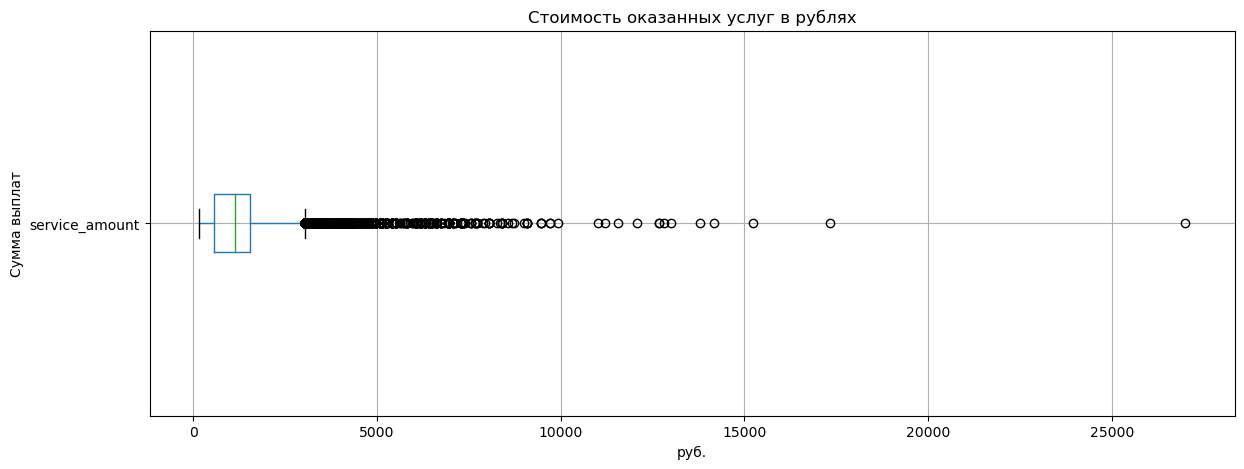

In [31]:
data.boxplot(column='service_amount', figsize=(14,5), vert = False) # Построим диаграмму размаха
plt.title("Стоимость оказанных услуг в рублях")
plt.xlabel("руб.")
plt.ylabel("Сумма выплат")
plt.show();

Разброс стоимости от 147 руб до 27000. Основной  диапазон - до 9000 руб. От 10000 до 15000 - единичные случаи. И единичное максимальное значение - 27000 руб., операция.  Таких услуг больше нет. Удалять ничего не будем, выбросами не считаем.

Рассмотрим более подробно столбец service_number.

In [32]:
data['service_number'].value_counts()

1     82452
2      1359
3       135
4        26
5        10
13        5
7         4
12        2
16        2
14        2
11        1
6         1
15        1
Name: service_number, dtype: int64

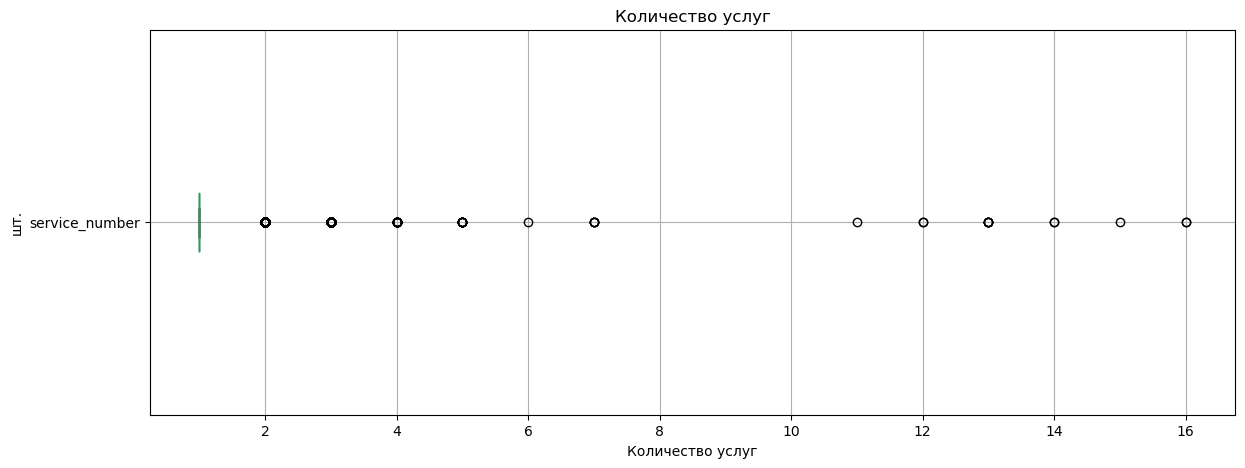

In [33]:
data.boxplot(column='service_number',figsize=(14,5), vert = False) # Построим диаграмму размаха
plt.title("Количество услуг")
plt.xlabel("Количество услуг")
plt.ylabel("шт.")
plt.show();

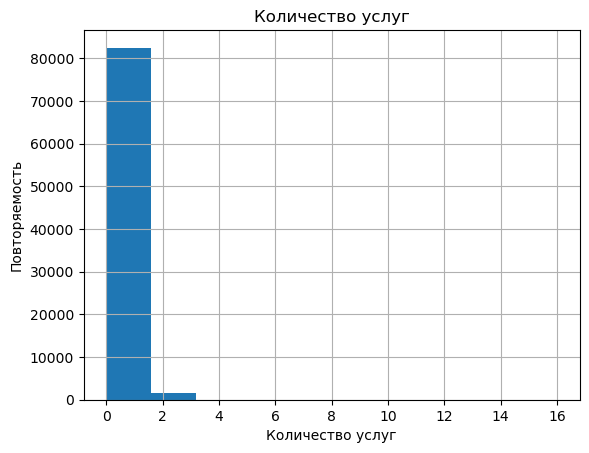

In [34]:
data['service_number'].hist(bins=10, range=(0, 16)) # Построим гистограмму
plt.title("Количество услуг")
plt.xlabel("Количество услуг")
plt.ylabel("Повторяемость")
plt.show()


Количество услуг варьируется от 1 до 16. Основная доля - 1 услуга.

Рассмотрим более подробно столбец age_for_service_date. Вывод стат. характеристик методом describe() выше показывает разброс min и max значений от 0 до 83 лет. 

In [35]:
data['age_for_service_date'].value_counts().head()

34    4132
30    3503
31    3415
37    3394
36    3341
Name: age_for_service_date, dtype: int64

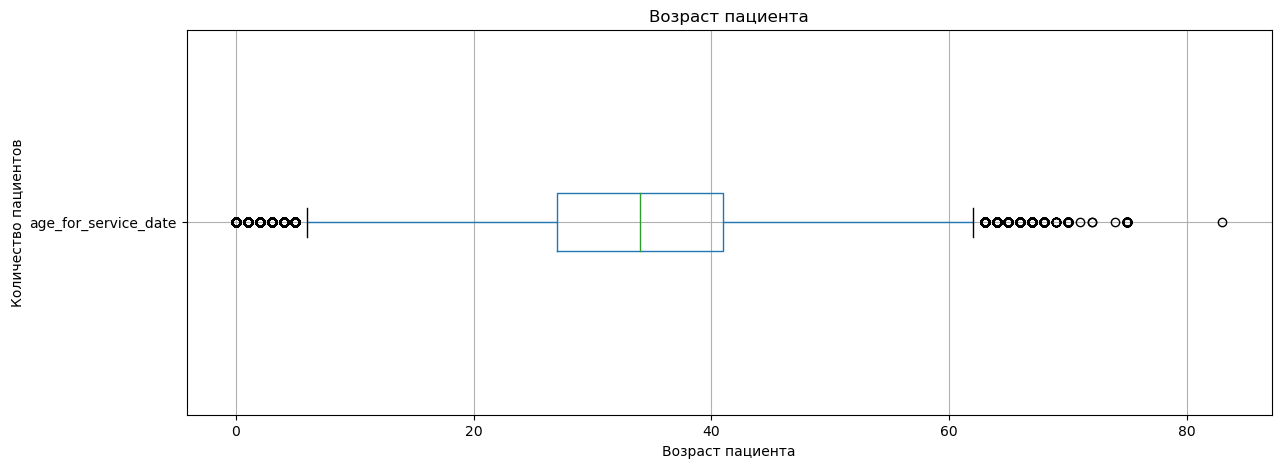

In [36]:
data.boxplot(column='age_for_service_date', figsize=(14,5), vert = False) # Построим диаграмму размаха
plt.title("Возраст пациента")
plt.xlabel("Возраст пациента")
plt.ylabel("Количество пациентов")
plt.show();

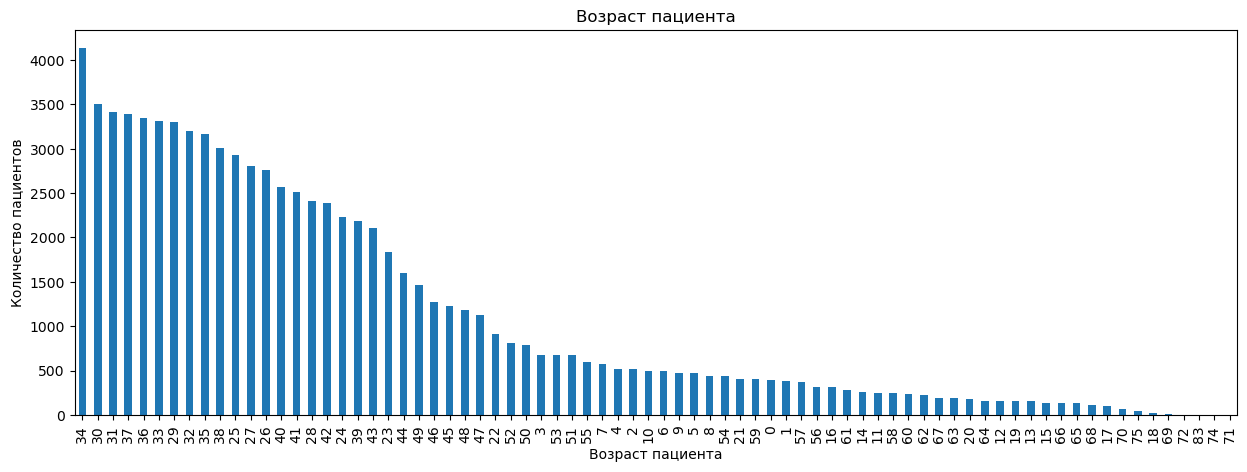

In [37]:
data['age_for_service_date'].value_counts().plot(kind = 'bar', figsize = (15, 5), title='Распределение возраста пациентов')
plt.title("Возраст пациента")
plt.xlabel("Возраст пациента")
plt.ylabel("Количество пациентов")
plt.show();

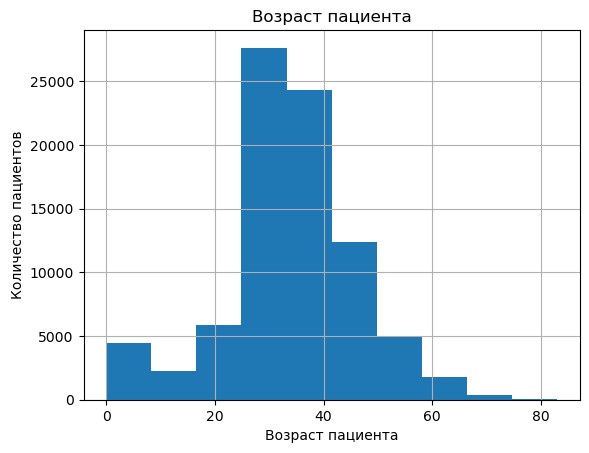

In [38]:
data['age_for_service_date'].hist()
plt.title("Возраст пациента")
plt.xlabel("Возраст пациента")
plt.ylabel("Количество пациентов")
plt.show();

Основная доля пациентов  возраста 30-40 лет. Единичное значение 83 года. Медиана не близка к среднему значению, диапазон (хвост) значений большой. Видим, что есть детский возраст. Клиника для всех возрастов.

####  Изучение категориального столбца sex_id.

In [39]:
data['sex_id'].value_counts()

женщина    51921
мужчина    32079
Name: sex_id, dtype: int64

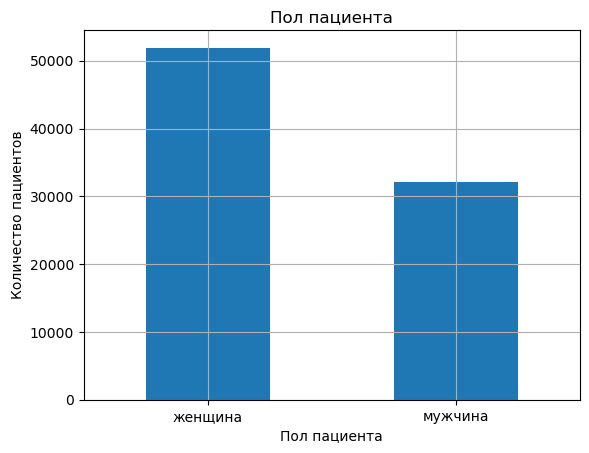

In [40]:
data.sex_id.value_counts().plot.bar(grid=True)
plt.title("Пол пациента")
plt.xlabel("Пол пациента")
plt.ylabel("Количество пациентов")
plt.xticks(rotation=0)
plt.show();

Услугами клиники пользуется почти в 1,5 раза женщин больше, чем мужчин.

####  Изучение периода данных.

In [41]:
data.service_year.unique()

array([2021, 2022], dtype=int64)

In [42]:
data.service_period.unique()

array(['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08'], dtype=object)

In [43]:
print(f'Минимальная дата в датасете {data.service_date.min()}, максимальная дата в датасете {data.service_date.max()}')

Минимальная дата в датасете 2021-01-03 00:00:00, максимальная дата в датасете 2022-08-31 00:00:00


Данные представлены с 3 января 2021 по 31 августа 2022г. за два года. 2022 г. второй неполный, представлен за 8 месяцев.

В результате исследовательского анализа выяснили:
* стоимость услуг (service_amount) находится в диапазоне от 147 до 27000 руб.;
* количество услуг (service_number)- от 1 до 16;
* возраст пациентов (age_for_service_date) - от 0 до 83 лет, основная доля пациентов - 30-40 лет;
* в числе пациентов женщин в 1,5 раза больше, чем мужчин;
* данные представлены за 2021г и 8 месяцев 2022г.

###  Добавление столбцов.

Добавим столбцы ранжирования по стоимости услуг и типу услуг. Также добавим столбец цены услуг.

In [44]:
# Создадим столбец ранжирования стоимости исходя их данных диаграммы размаха. 
def categorize_service_amount(amount):
    if amount <=3000:
        return 'Низкая стоимость'
    if 3001 <= amount <= 9000:
        return 'Средняя стоимость'
    if amount >=9001:
        return 'Высокая стоимость' 

In [45]:
data['category_service_amount'] = data['service_amount'].apply(categorize_service_amount)

In [46]:
#Создадим столбец 'category_service_name' для разбиения услуг на более крупные категории
classification_dict = {'консультация':['прием','осмотр','консультация', 'приём'],                       
                       'лечение': ['терапия','токи','сеанс','форез','массаж','подбор','инъекция','анестезия',
                                   'промывание','лечение','туалет','блокада','перевязка','смазывание','удаление',                                   'инстилляция','продувание','обработка','инстиляция','аппликация',\
                                   'швов','инфузия','повязк','лекарст','иммобил','вскрыт','введен','лфк','компрес',                                  'тампонада','лечеб','катетер','вакцинация','ингаляция','санац','репозиц',\
                                   'зондирование','шинирование','криодеструкция','пребывание','коагуляция',                                   'пункция с введением лекарственного средства','лечебная пункция','лечебно-диагностическая',\
                                   'пункция гайморовой пазухи'],                     
                       'диагностика':['метрия','ультразвук','экг','глазн','графия',
                                     'сканирование','бинокул','скопия','эндоскоп','монитор','диагност',                                     'расшиф','функц','вестибул','узи','камертон','пункц','пункт',\
                                     'биопсия','мскт','цитолог','мрт','цветоощущ','пренатал',]}


In [47]:
def categories(purpose):
    for category, items_list in classification_dict.items():
        for item in items_list:
            if item in purpose:
                return category 
    return 'лабораторная диагностика'            

In [48]:
data['category_service_name'] = data['service_name'].apply(categories)

In [49]:
data['category_service_amount'].unique()

array(['Низкая стоимость', 'Средняя стоимость', 'Высокая стоимость'],
      dtype=object)

In [50]:
data['price'] = data['service_amount']/data['service_number'] #Создадим столбец 'price'

In [51]:
data.price.describe()

count   84000.00
mean     1144.92
std       779.38
min       147.00
25%       540.00
50%      1120.00
75%      1530.00
max     26999.00
Name: price, dtype: float64

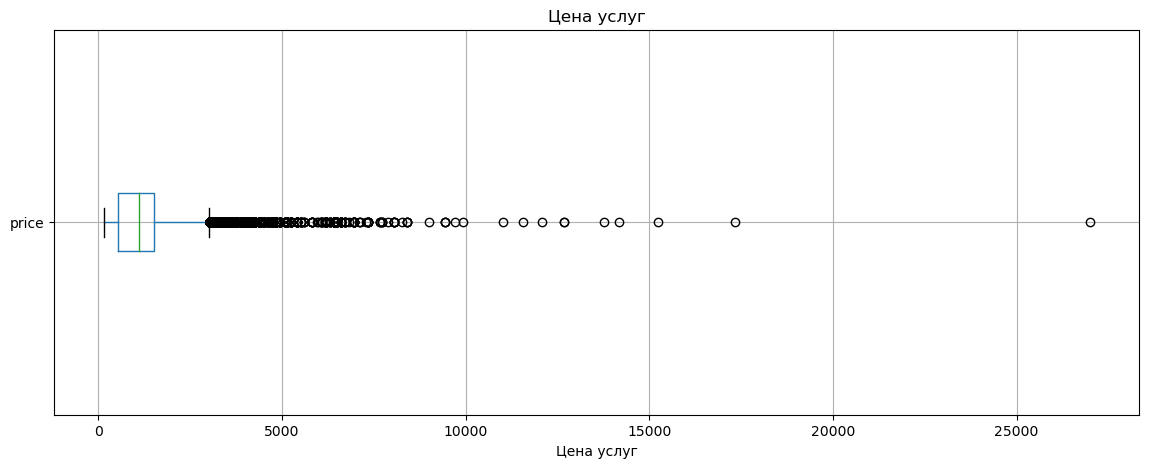

In [52]:
data.boxplot(column='price', figsize=(14,5), vert = False) # Построим диаграмму размаха
plt.title("Цена услуг")
plt.xlabel("Цена услуг")
plt.show();

Цены на услуги в диапазоне от 147 до 27000, единичные значения около 10000 и более.

In [53]:
#Создадим столбец 'age_group' для разбиения клиентов на более крупные категории по возрасту.
def age_group_func(data):    
    if data['age_for_service_date'] < 18:
        val = 'дети и подростки'
    elif data['age_for_service_date'] >=18 and data['age_for_service_date'] <= 44:
        val = 'молодой возраст'
    elif data['age_for_service_date'] >=45 and data['age_for_service_date'] <= 59:
        val = 'средний возраст'
    elif data['age_for_service_date'] >=60 and data['age_for_service_date'] <= 74:
        val = 'пожилой возраст'    
    else:
        val = 'старческий возраст'
    return val    
data['age_group'] = data.apply(age_group_func, axis=1)
data['age_group'].unique()

array(['молодой возраст', 'средний возраст', 'дети и подростки',
       'пожилой возраст', 'старческий возраст'], dtype=object)

Добавили столбцы:
* категории стоимости услуг (category_service_amount),
* категории услуг (category_service_name),
* цена услуги (price);
* категория по возрасту (age_group).

<a id="data_delta_measurement"></a> 
## Анализ динамики выручки/цены лечения.

In [54]:
# группируем данные и считаем  доход
data_rev = data.groupby('service_period', as_index = False)['service_amount'].sum() 

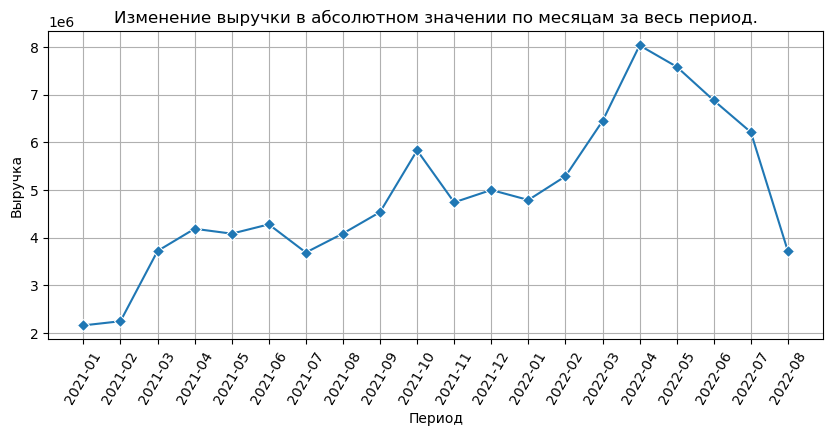

In [55]:
plt.figure(figsize=(10, 4))
plt.grid()
sns.lineplot(x='service_period', y='service_amount', data=data_rev, marker='D' )

plt.title('Изменение выручки в абсолютном значении по месяцам за весь период.')
plt.xlabel('Период')
plt.ylabel('Выручка')
plt.xticks(rotation=60)
plt.show();

В 2021г тренд на увеличение выручки, скачки увеличения произошли в феврале 2022октябре 2022. В апреле 2022 резкий скачок выручки, затем с мая по август стремительное падение.

In [56]:
# посчитаем медианный доход месяц к месяцу
data_rev_month = data.groupby(['service_month', 'service_year'], \
                        as_index = False)['service_amount'].median()

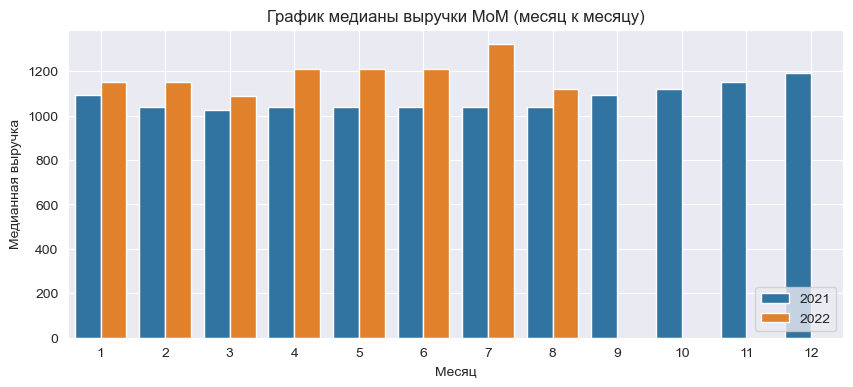

In [57]:
sns.set_style('dark')
plt.figure(figsize=(10, 4))
sns.barplot(x='service_month', y='service_amount', data=data_rev_month, hue='service_year')
plt.title('График медианы выручки MoM (месяц к месяцу)')
plt.xlabel('Месяц')
plt.ylabel('Медианная выручка')
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show();

Рост выручки месяц к месяцу в 2022г. по отношению к 2021г.

In [58]:
# посчитаем медиану цены месяц к месяцу
data_price_month = data.groupby(['service_month', 'service_year'], \
                        as_index = False)['price'].median()

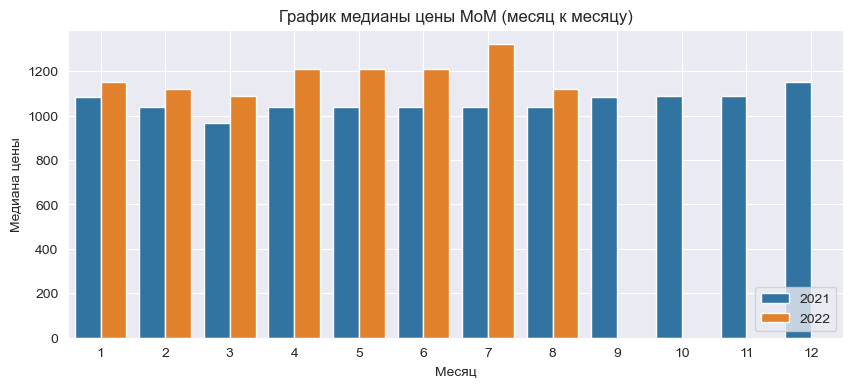

In [59]:
sns.set_style('dark')
plt.figure(figsize=(10, 4))
sns.barplot(x='service_month', y='price', data=data_price_month, hue='service_year')
plt.title('График медианы цены MoM (месяц к месяцу)')
plt.xlabel('Месяц')
plt.ylabel('Медиана цены')
# выбираем положение легенды и указываем размер шрифта
plt.legend(loc='lower right', fontsize=10)
plt.grid()
plt.show();

По аналогии с выручкой видим рост цен месяц к месяцу в 2022г. по отношению к 2021г.

Рассмотрим отдельно года и доли выручки по месяцам.

In [60]:
data_21 = data.query('service_year == 2021')
rev_month_21 = (data_21.groupby('service_month')['service_amount'].sum()
                      .reset_index() 
                )

rev_month_21['share_service_amount_2021г.'] = round((rev_month_21['service_amount']/data_21['service_amount'].sum()),2)

In [61]:
data_22 = data.query('service_year == 2022')
rev_month_22 = (data_22.groupby('service_month')['service_amount'].sum()
                      .reset_index() 
                )

rev_month_22['share_service_amount_2022г.'] = round((rev_month_22['service_amount']/data_22['service_amount'].sum()),2)

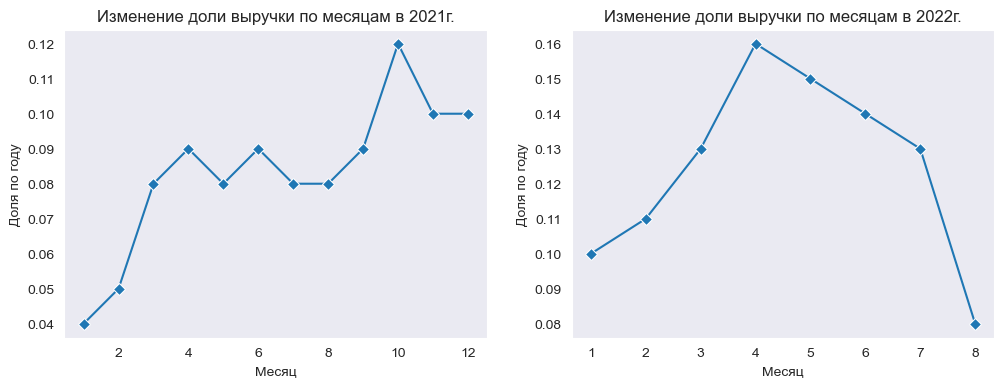

In [62]:
plt.figure(figsize=(12, 4)) 

ax1 = plt.subplot(1, 2, 1)
sns.lineplot(x='service_month', y='share_service_amount_2021г.', data=rev_month_21, marker='D',ax=ax1 )

plt.title('Изменение доли выручки по месяцам в 2021г.')
plt.xlabel('Месяц')
plt.ylabel('Доля по году')

ax2 = plt.subplot(1, 2, 2)
sns.lineplot(x='service_month', y='share_service_amount_2022г.', data=rev_month_22, marker='D',ax=ax2 )
plt.title('Изменение доли выручки по месяцам в 2022г.')
plt.xlabel('Месяц')
plt.ylabel('Доля по году')
plt.show()

В 2021г. пик доли выручки по году приходится на октябрь, в 2022г. резкий рост в апреле и спад ниже начального уровня года.

Выведем основные абсолютные и относительные показатели.

In [63]:
tab = data.pivot_table(index=['service_year', 'service_month'], values=['service_amount','service_number', 'insured'],\
                                aggfunc={'service_amount':"sum",'service_number':"sum", 'insured':"nunique"})\
                                .reset_index()
tab.columns=['service_year', 'service_month','clients_cnt', 'service_amt', 'service_num']

# рассчитаем % изменение с шагом 12 месяцев

tab['clients_delta, %']=round(tab['clients_cnt'].pct_change(12)*100,1)
tab['service_amt_delta, %']=round(tab['service_amt'].pct_change(12)*100,1)
tab['service_num_delta, %']=round(tab['service_num'].pct_change(12)*100,1)
tab['amt_per_client'] = round(tab['service_amt']/tab['clients_cnt'],1)
tab['amt_per_service'] = round(tab['service_amt']/tab['service_num'],1)
tab['service_amt_k_rub'] = tab['service_amt']/1000
tab['amt_per_client_delta, %']= round(tab['amt_per_client'].pct_change(12)*100,1)
tab['amt_per_service_delta, %']= round(tab['amt_per_service'].pct_change(12)*100,1)
tab

,service_year,service_month,clients_cnt,service_amt,service_num,"clients_delta, %","service_amt_delta, %","service_num_delta, %",amt_per_client,amt_per_service,service_amt_k_rub,"amt_per_client_delta, %","amt_per_service_delta, %"
0,2021,1,286,2163556,1999,NaN,NaN,NaN,7564.90,1082.30,2163.56,NaN,NaN
1,2021,2,309,2250655,2067,NaN,NaN,NaN,7283.70,1088.90,2250.66,NaN,NaN
2,2021,3,445,3723099,3626,NaN,NaN,NaN,8366.50,1026.80,3723.10,NaN,NaN
3,2021,4,466,4189228,3847,NaN,NaN,NaN,8989.80,1089.00,4189.23,NaN,NaN
4,2021,5,468,4086463,3765,NaN,NaN,NaN,8731.80,1085.40,4086.46,NaN,NaN
5,2021,6,433,4281485,3832,NaN,NaN,NaN,9888.00,1117.30,4281.48,NaN,NaN
6,2021,7,447,3691602,3511,NaN,NaN,NaN,8258.60,1051.40,3691.60,NaN,NaN
7,2021,8,488,4089943,3735,NaN,NaN,NaN,8381.00,1095.00,4089.94,NaN,NaN
8,2021,9,559,4538454,4174,NaN,NaN,NaN,8118.90,1087.30,4538.45,NaN,NaN
9,2021,10,591,5833320,5009,NaN,NaN,NaN,9870.30,1164.60,5833.32,NaN,NaN


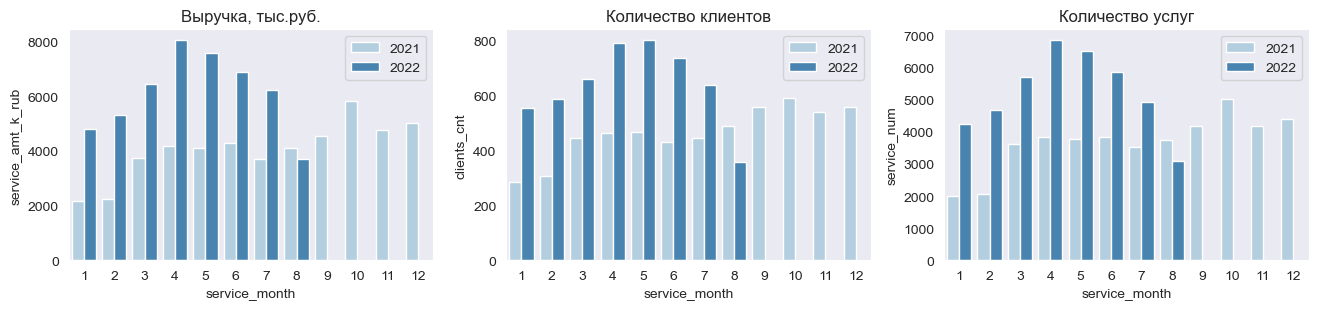

In [64]:
# построим графики динамики выручки, числа клиентов, числа оказанных услуг по годам:
plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
ax = sns.barplot(x='service_month', y = 'service_amt_k_rub', data = tab, hue = 'service_year', palette="Blues")\
        .set(title='Выручка, тыс.руб.')
plt.legend(loc = 'upper right')
plt.subplot(1,3,2)
ax = sns.barplot(x='service_month', y = 'clients_cnt', data = tab, hue = 'service_year', palette="Blues")\
        .set(title='Количество клиентов')
plt.legend(loc = 'upper right')
plt.subplot(1,3,3)
ax = sns.barplot(x='service_month', y = 'service_num', data = tab, hue = 'service_year', palette="Blues")\
        .set(title='Количество услуг')
plt.legend(loc = 'upper right')
plt.show();

В абсолютных показателях и выручка, и количество клиентов, и количество услуг месяц к месяцу в 2022г превышает показатели 2021г. Пик приходится на апрель и май 2022 и резкое падение к августу 2022г. Значение показателей августа 2022г. ниже августа 2021г.

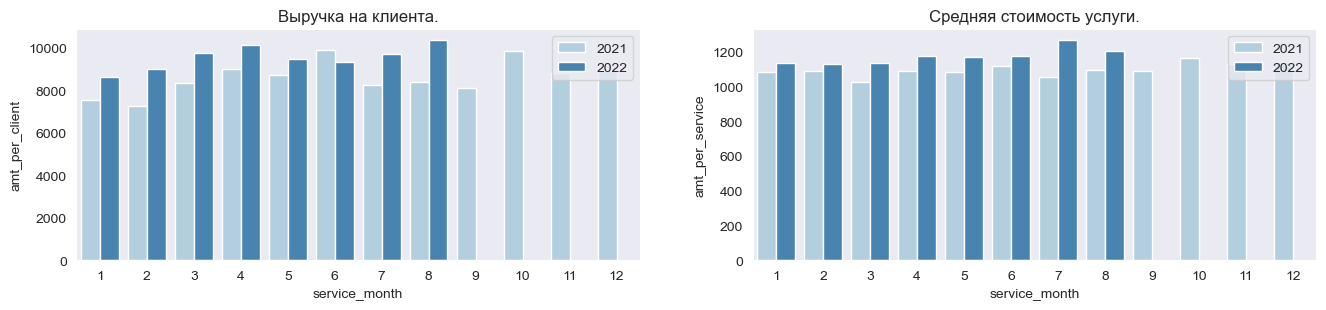

In [65]:
# построим графики динамики выручки на 1 клиента и средней стоимости 1 услуги по годам:
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)
ax = sns.barplot(x='service_month', y = 'amt_per_client', data = tab, hue = 'service_year', palette="Blues")\
        .set(title='Выручка на клиента.')
plt.legend(loc = 'upper right')
plt.subplot(1,2,2)
ax = sns.barplot(x='service_month', y = 'amt_per_service', data = tab, hue = 'service_year', palette="Blues")\
        .set(title='Средняя стоимость услуги.')
plt.legend(loc = 'upper right')
plt.show();

Показатель выручки на клиента в 2022г. выше, за исключением июня 2022г. Средняя стоимость услуги в 2022г. стабильно выше, чем в 2021г. Отметим, что не смотря на скачок выручки, количества клиентов и услуг в апреле-мае 2022г. прирост выручки на клиента не такой существенный.

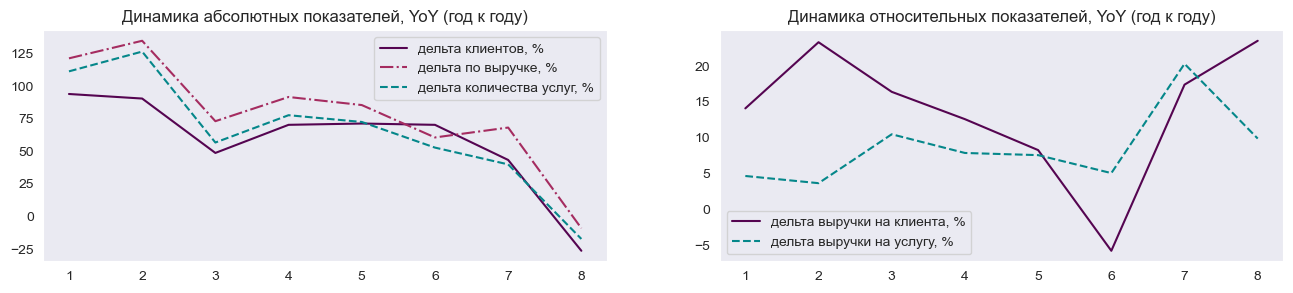

In [66]:
# построим графики динамики приростов выручки, числа клиентов и кол-ва оказанных услуг для 8 мес 2022г:
yoy_2022 = tab[tab['service_year'] == 2022]
plt.figure(figsize=(16,3))
plt.subplot(1,2,1)

plt.plot(yoy_2022['service_month'],yoy_2022['clients_delta, %'], label= 'дельта клиентов, %', color = '#550551')
plt.plot(yoy_2022['service_month'],yoy_2022['service_amt_delta, %'], label= 'дельта по выручке, %', linestyle = '-.', \
         color = '#a52c60')
plt.plot(yoy_2022['service_month'],yoy_2022['service_num_delta, %'], label= 'дельта количества услуг, %', linestyle = '--', \
         color='#05878a')
plt.title('Динамика абсолютных показателей, YoY (год к году)')
plt.legend()

plt.subplot(1,2,2)

plt.plot(yoy_2022['service_month'],yoy_2022['amt_per_client_delta, %'], label= 'дельта выручки на клиента, %', color = '#550551')
plt.plot(yoy_2022['service_month'],yoy_2022['amt_per_service_delta, %'], label= 'дельта выручки на услугу, %', \
         linestyle = '--', color='#05878a')
plt.title('Динамика относительных показателей, YoY (год к году)')
plt.legend()
plt.show();

Положительная динамика абсолютных показателей по дельте клиентов , дельте выручки, дельте количества услуг к августу 2022 стала отрицательной. Относительный показатель дельты выручки на клиента сохранил положительную динамику в отличие от дельты выручки на услугу.

In [67]:
# построим разброс стоимости услуг - динамику среднего чека (выручка на 1 посетителя за 1 визит
#- т.е. если клиент в 1 день пользовался несколькими услугами -их стоимости суммируются)
data_1 = data.pivot_table(index=['service_period','service_date','insured'], values = 'service_amount', aggfunc = 'sum').reset_index()


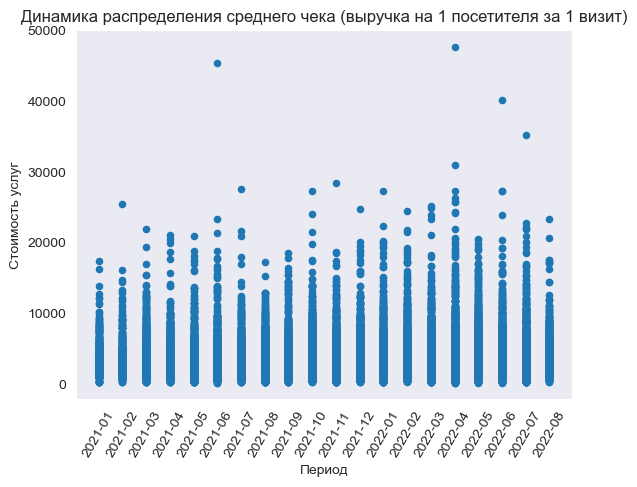

In [68]:
data_1.plot('service_period', y='service_amount', kind='scatter')
plt.title('Динамика распределения среднего чека (выручка на 1 посетителя за 1 визит)')
plt.xlabel('Период')
plt.ylabel('Стоимость услуг')
plt.xticks(rotation=60)
plt.show();

In [69]:
data_2 = data_1.pivot_table(index='service_period',values = 'service_amount', aggfunc = 'mean').reset_index()
data_2.columns = ['service_period', 'bill_mean']
data_2['bill_mean'] = round(data_2['bill_mean'],1)

data_2['bill_mean, yoy'] = round(data_2['bill_mean'].pct_change(12)*100,1)
data_2['bill_mean, mom'] = round(data_2['bill_mean'].pct_change()*100,1)
data_2

,service_period,bill_mean,"bill_mean, yoy","bill_mean, mom"
0,2021-01,2911.90,NaN,NaN
1,2021-02,2802.80,NaN,-3.70
2,2021-03,3163.20,NaN,12.90
3,2021-04,2948.10,NaN,-6.80
4,2021-05,3077.20,NaN,4.40
5,2021-06,3197.50,NaN,3.90
6,2021-07,3011.10,NaN,-5.80
7,2021-08,3002.90,NaN,-0.30
8,2021-09,2833.00,NaN,-5.70
9,2021-10,3199.80,NaN,12.90


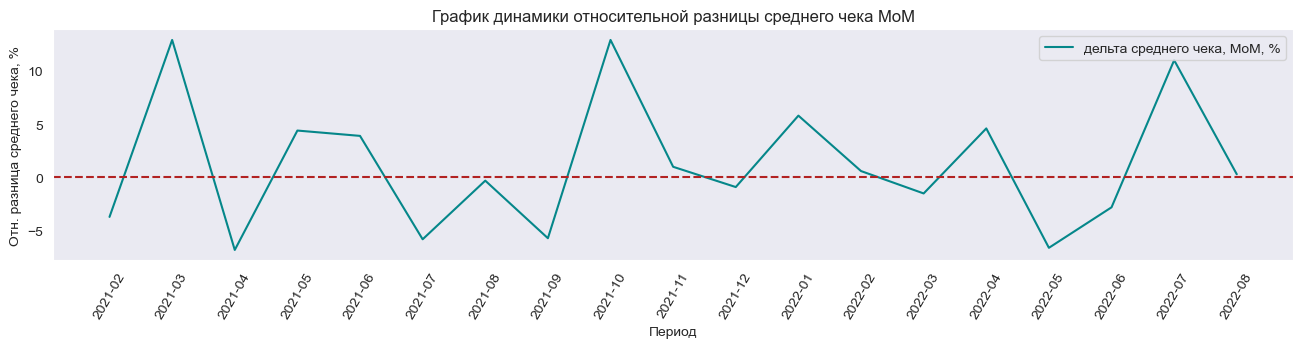

In [70]:
# построим график динамики относительной разницы среднего чека MoM:

plt.figure(figsize=(16,3))
plt.plot(data_2['service_period'],data_2['bill_mean, mom'], label= 'дельта среднего чека, MoM, %', color = '#05878a')          

plt.title('График динамики относительной разницы среднего чека MoM')
plt.legend()
plt.xticks(rotation=60)
plt.legend(loc = 'upper right')
plt.axhline(y=0, color='firebrick', linestyle='--')
plt.xlabel('Период')
plt.ylabel('Отн. разница среднего чека, %')
plt.show();

In [71]:
# посмотрим на относительные средние цены MoM 
data_price = data.pivot_table(index=['service_period'], values = 'price', aggfunc = 'mean').reset_index()
data_price['price_mean, mom'] = round(data_price['price'].pct_change()*100,1)

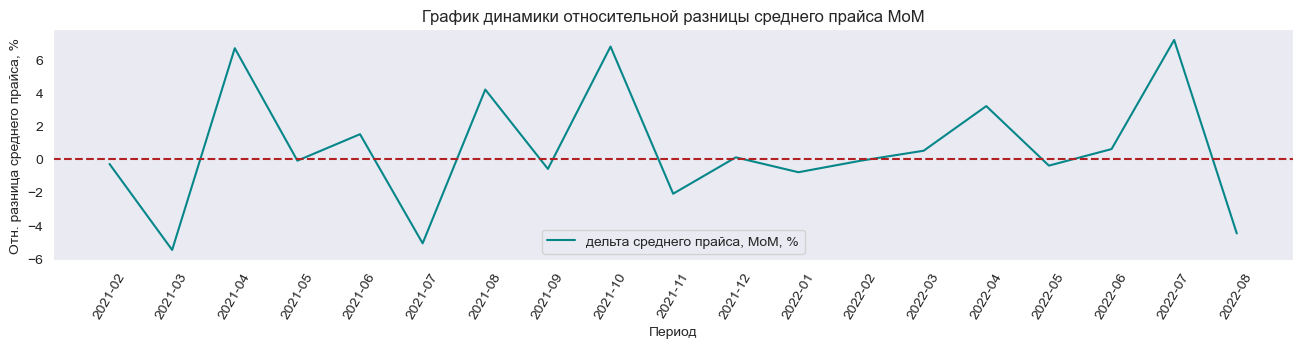

In [72]:
# построим график динамики относительной разницы среднего значения прайса MoM:

plt.figure(figsize=(16,3))
plt.plot(data_price['service_period'],data_price['price_mean, mom'], label= 'дельта среднего прайса, MoM, %', color = '#05878a')          

plt.title('График динамики относительной разницы среднего прайса MoM')
plt.legend()
plt.xticks(rotation=60)
plt.legend
plt.axhline(y=0, color='firebrick', linestyle='--')
plt.xlabel('Период')
plt.ylabel('Отн. разница среднего прайса, %')
plt.show();

**Выводы по разделу** - описание динамики выручки:

* для анализа доступны данные за полный 2021г. и 8 месяцев 2022г. - поэтому суммарными годовыми показателями выручки мы не можем оперировать, однако можно сравнивать помесячную динамику и показатели год к году для января-августа 2022г.
* по абсолютным величинам (выручка за месяц, число уникальных клиентов за месяц, число оказанных услуг) в первые 7 мес 2022г медцентр показывает существенное опережение относительно 2021г, но начиная с июня есть расхождения в динамике - так, выручка и кол-во оказанных услуг в июне 2021г показывают небольшой рост относительно мая 2021, а в 2022г в июне происходит ощутимое падение. При этом кол-во клиентов в июле 2021г растет относительно клиентов июня, а в 2022 - снижается. **В августе 2022г абсолютные показатели резко снижаются и уходят на уровень ниже аналогичных в 2021г.**
* в процентном выражении YoY (год к году) в январе-феврале наблюдаем рост на 100% относительно аналогичных периодов 2021г (обратим внимание, что рост показателей произошел с октября 2021г, если анализировать в абсолютных величинах), далее в марте-июле прирост уменьшается до уровня +50-75% к данным 2021г, в августе драматично падает до -25%.
* при анализе помесячных удельных показателей (выручка на клиента - соотносим выручку за месяц с числом уникальных клиентов, средняя стоимость услуги - соотносим выручку за месяц с кол-вом оказанных услуг) видим, что **выручка на клиента в июне в 2022г ниже, чем в 2021г, при этом в 2021г с июня по август наблюдаем снижение и стабилизацию показателя, в 2022г - медленный рост**. Стоимость услуги в 2022г во всех доступных периодах выше, чем в 2021г, причем для 2022г характерен плавный рост показателя в динамике (в 2021г были просадки).
* при анализе динамики приростов YoY относительных показателей (выручка на клиента, средняя стоимость услуги) интересно выделить, что в феврале и в августе 2022г рост выручки на клиента относительно 2021г составил более 20%, в то время как стоимость услуги приросла на 5-7%, в июне выручка на клиента практически сравнялась с данными 2021г, при роста средней стоимости услуги на 7% относительно 2021г.
* если анализировать статистику показателя сумма на клиента за визит (т.е. сумма потраченных клиентом денег за 1 день) - распределения по месяцам близки между собой, но в 2022г. бОльшее число значений уходят в верхние выбросы.
* по статистике изменения среднего чека можно отметить рост среднего значения в марте, октябре 2021г. и рост в июле 2022г с дальнейшим снижением в августе.
* по статистике изменения среднего значения цены услуг можно отметить относительный рост в апреле , августе, октябре 2021г., апреле и июле 2022г.

Таким образом, в первую очередь в рамках анализа хочется понять, какие факторы вызвали падение выручки и др. показателей начиная с июня 2022г, что в итоге привело к тому, что абсолютные значения в августе 2022г упали ниже 2021г, при имевшем до этого место превышении 50%+ на динамике YoY.

<a id="suggestions"></a> 
## Факторы, повлиявшие на выручку/цену лечения.

Проверим 3 фактора, которые могли привести к падению выручки медцентра.

<a id="suggestion1"></a> 
### Влияние половозрастной структуры пациентов на выручку.

Рассмотрим категорию пола.

In [73]:
gender = data.groupby('sex_id')['insured'].agg('nunique').reset_index()
gender.columns = ['пол','количество пациентов']

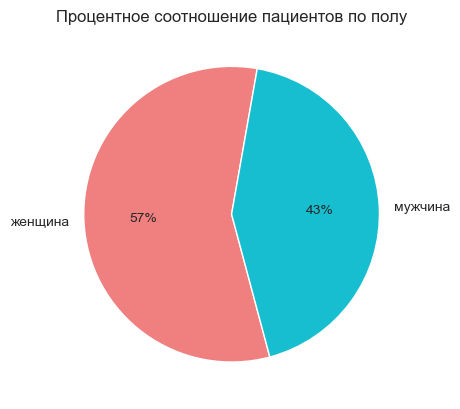

In [74]:
vals = gender['количество пациентов']
labels = gender['пол']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.0f%%', startangle=80, colors = ['lightcoral', '#17becf'])
ax.set_title("Процентное соотношение пациентов по полу")                                             
plt.show()

In [75]:
gender_visit = data['sex_id'].value_counts().reset_index()
gender_visit.columns = ['пол','количество визитов']

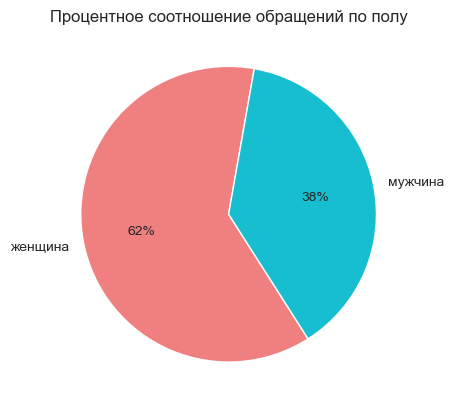

In [76]:
vals = gender_visit['количество визитов']
labels = gender_visit['пол']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.0f%%', startangle=80, colors = ['lightcoral', '#17becf'])
ax.set_title("Процентное соотношение обращений по полу")                                             
plt.show()

Процентное соотношение пациентов женщин и мужчинам 57% и 43% соответственно. При этом количество визитов женщин чаще - 62%.

In [77]:
sex_cnt = data.groupby('sex_id').agg({'record_id':'count', 'insured':'nunique'}).reset_index()
sex_cnt['ratio'] = round(sex_cnt['record_id']/sex_cnt['insured'])
sex_cnt.columns=['пол','кол-во обращений','кол-во застрахованных','кол-во обращений на застрахованного']
sex_cnt

,пол,кол-во обращений,кол-во застрахованных,кол-во обращений на застрахованного
0,женщина,51921,2555,20.00
1,мужчина,32079,1932,17.00


В среднем на женщину приходится 20 обращений за весь период, на мужчину - 17. Женщины чаще обращаются.

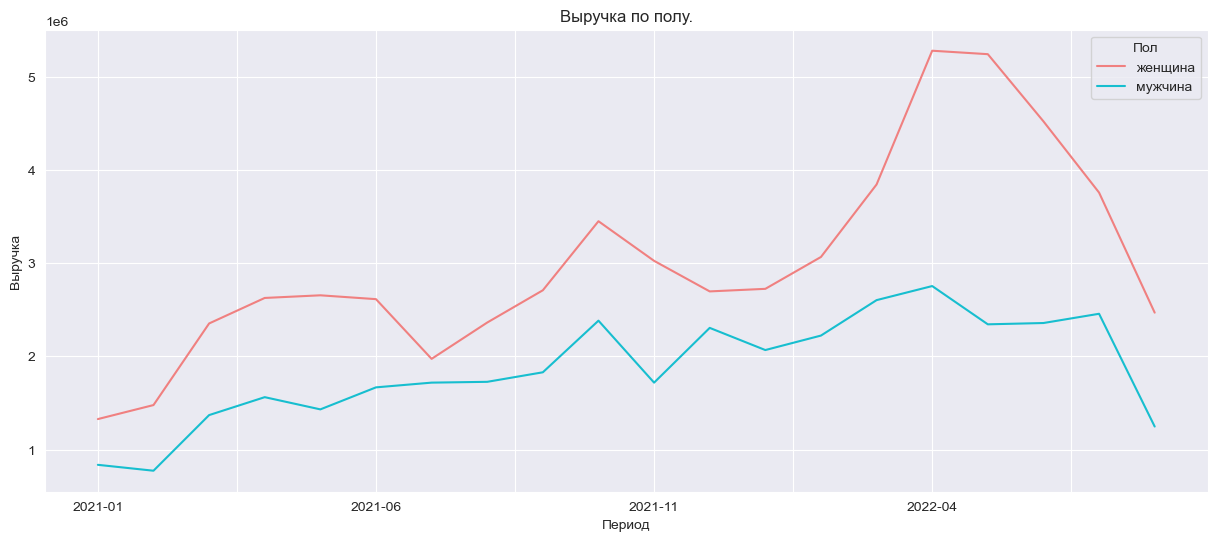

In [78]:
(data.pivot_table(index = 'service_period', columns = 'sex_id', values = 'service_amount', aggfunc = 'sum')
    .plot(figsize=(15,6), color = ['lightcoral', '#17becf'], grid=True));
plt.xlabel('Период')
plt.ylabel('Выручка')
plt.legend(title='Пол')
plt.title('Выручка по полу.')
plt.show();

Отмечаем скачок количества пациентов-женщин в апреле 2022г. Также как мы помним в апреле скачок выручки. В дальнейшем снижение выручки по обоим полам.

In [79]:
age = data.groupby('age_group')['service_amount'].agg(['sum', 'count', 'mean']).reset_index()
age.columns=['группа','выручка','кол-во','средняя выручка']
age

,группа,выручка,кол-во,средняя выручка
0,дети и подростки,7554633,6831,1105.93
1,молодой возраст,74422177,63788,1166.71
2,пожилой возраст,2143656,1750,1224.95
3,средний возраст,13387898,11582,1155.92
4,старческий возраст,46690,49,952.86


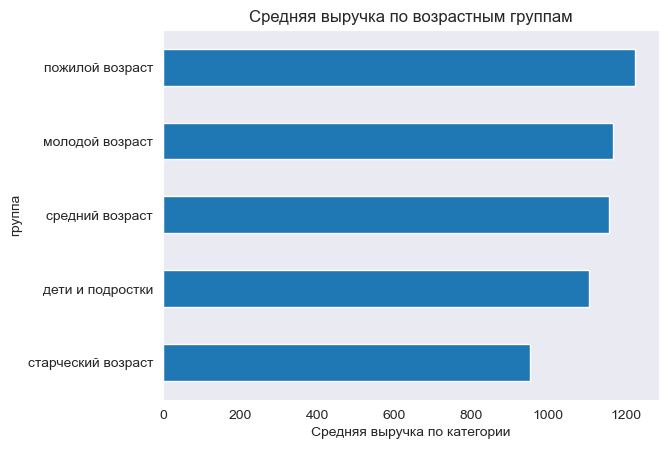

In [80]:
(age.sort_values(by='средняя выручка')
    .plot(kind='barh', x='группа', y='средняя выручка', legend=False, xlabel='', title = 'Средняя выручка по возрастным группам'));
plt.xlabel('Средняя выручка по категории')
plt.show();

Средняя выручка по группам молодого и среднего возраста приблизительно одинаковая, немного выше выручка от пациентов пожилого возраста.

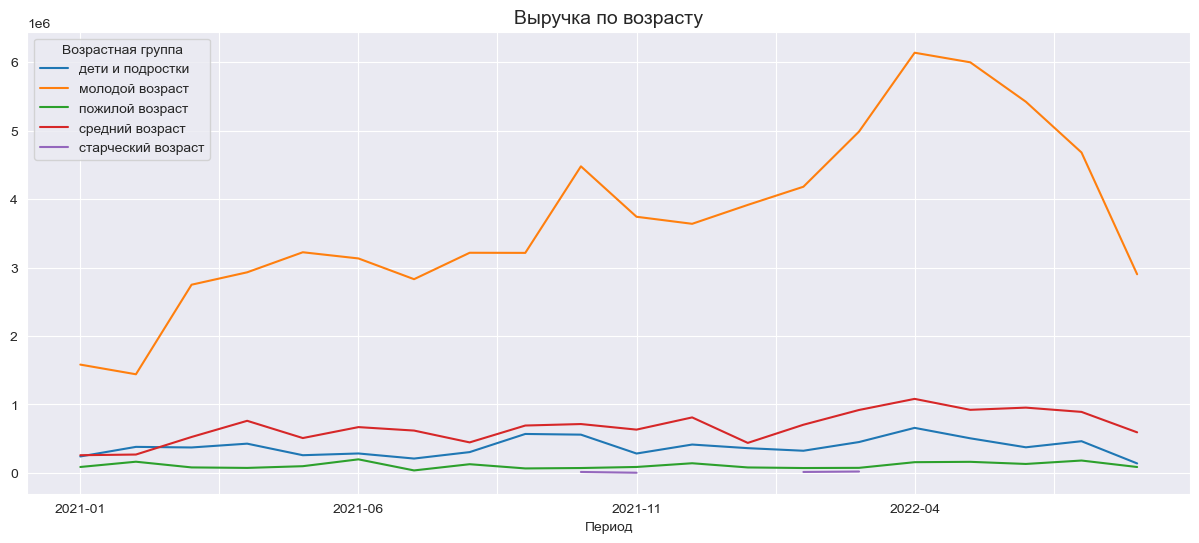

In [81]:
(data.pivot_table(index =  'service_period', columns = 'age_group', values = 'service_amount', aggfunc = 'sum')
    .plot(figsize=(15,6), grid=True).set_title('Выручка по возрасту', fontsize=14))
plt.xlabel('Период')
plt.legend(title='Возрастная группа')
plt.show();

Основную выручку приносят пациенты молодого возраста от 18 до 44 лет. Доля остальных категорий приблизительно на одном уровне. 

In [82]:
# проанализируем динамику по возрасту обращавшихся в медцентр пациентов. В данном случае нас интересуют не уникальные клиенты, а 
# распределение клиентов по оказанным услугам (клиент с 10 услугами повлияет на выручку сильнее, чем клиент с 1):

age_structure_fig= data.pivot_table(index=['service_period', 'age_group'], values='insured', aggfunc=('count')).reset_index()
age_structure_fig.columns=['service_period','age_group', 'num_clients']
age_structure_add = age_structure_fig.pivot_table(index = 'service_period', values = 'num_clients', aggfunc = 'sum').reset_index()
age_structure_add.columns = ['service_period','num_clients_total']
age_structure_fig = age_structure_fig.merge(age_structure_add, on = 'service_period', how = 'left')
age_structure_fig['share_age_group'] = round(age_structure_fig['num_clients']/age_structure_fig['num_clients_total']*100,1)

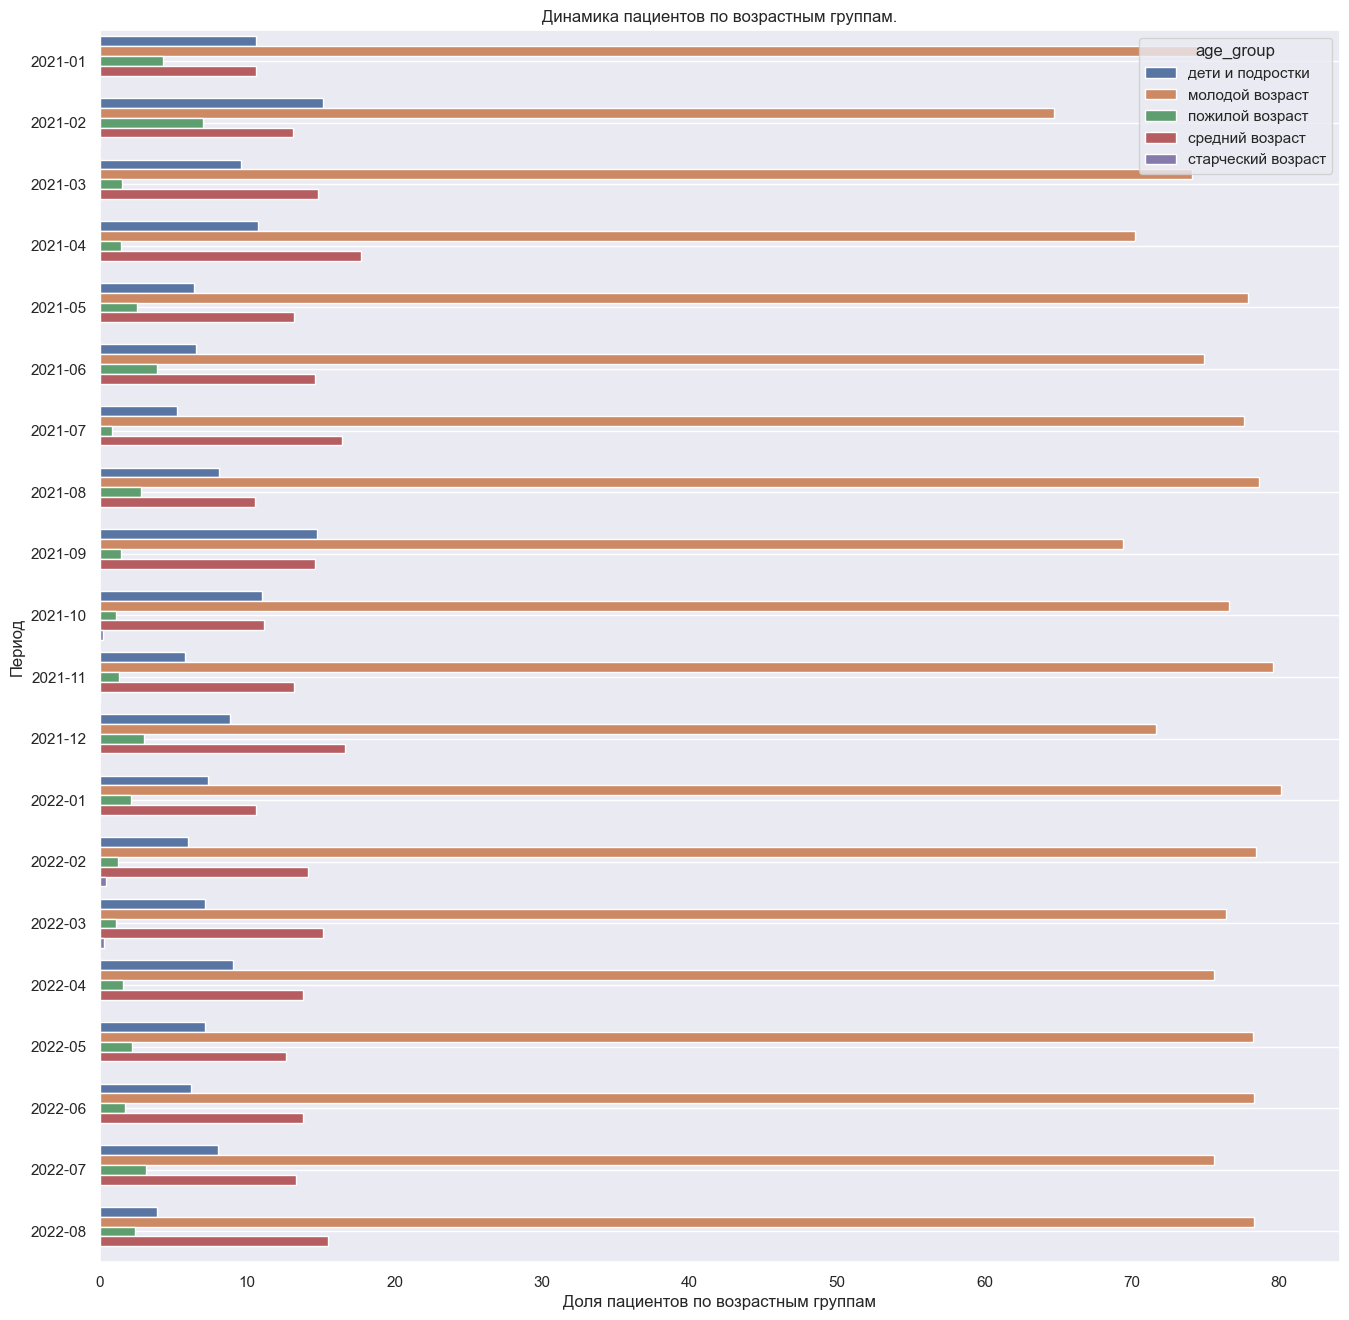

In [83]:
sns.set_style('dark')
sns.set_theme(rc={'figure.figsize':(16,16)})
sns.barplot(x='share_age_group', y='service_period', data=age_structure_fig, hue='age_group')
plt.title('Динамика пациентов по возрастным группам.')
plt.xlabel('Доля пациентов по возрастным группам')
plt.ylabel('Период')
plt.legend
plt.grid()
plt.show();

По графику можем сказать, что доли пациентов возрастных групп практически не менялись.

In [84]:
# проанализируем динамику по возрасту обращавшихся в медцентр пациентов. 
gender_structure_fig= data.pivot_table(index=['service_period', 'sex_id'], values='insured', aggfunc=('count')).reset_index()
gender_structure_fig.columns=['service_period','sex_id', 'num_clients']
gender_structure_add = gender_structure_fig.pivot_table(index = 'service_period', values = 'num_clients', aggfunc = 'sum').reset_index()
gender_structure_add.columns = ['service_period','num_clients_total']
gender_structure_fig = gender_structure_fig.merge(gender_structure_add, on = 'service_period', how = 'left')
gender_structure_fig['share_gender'] = round(gender_structure_fig['num_clients']/gender_structure_fig['num_clients_total']*100,1)


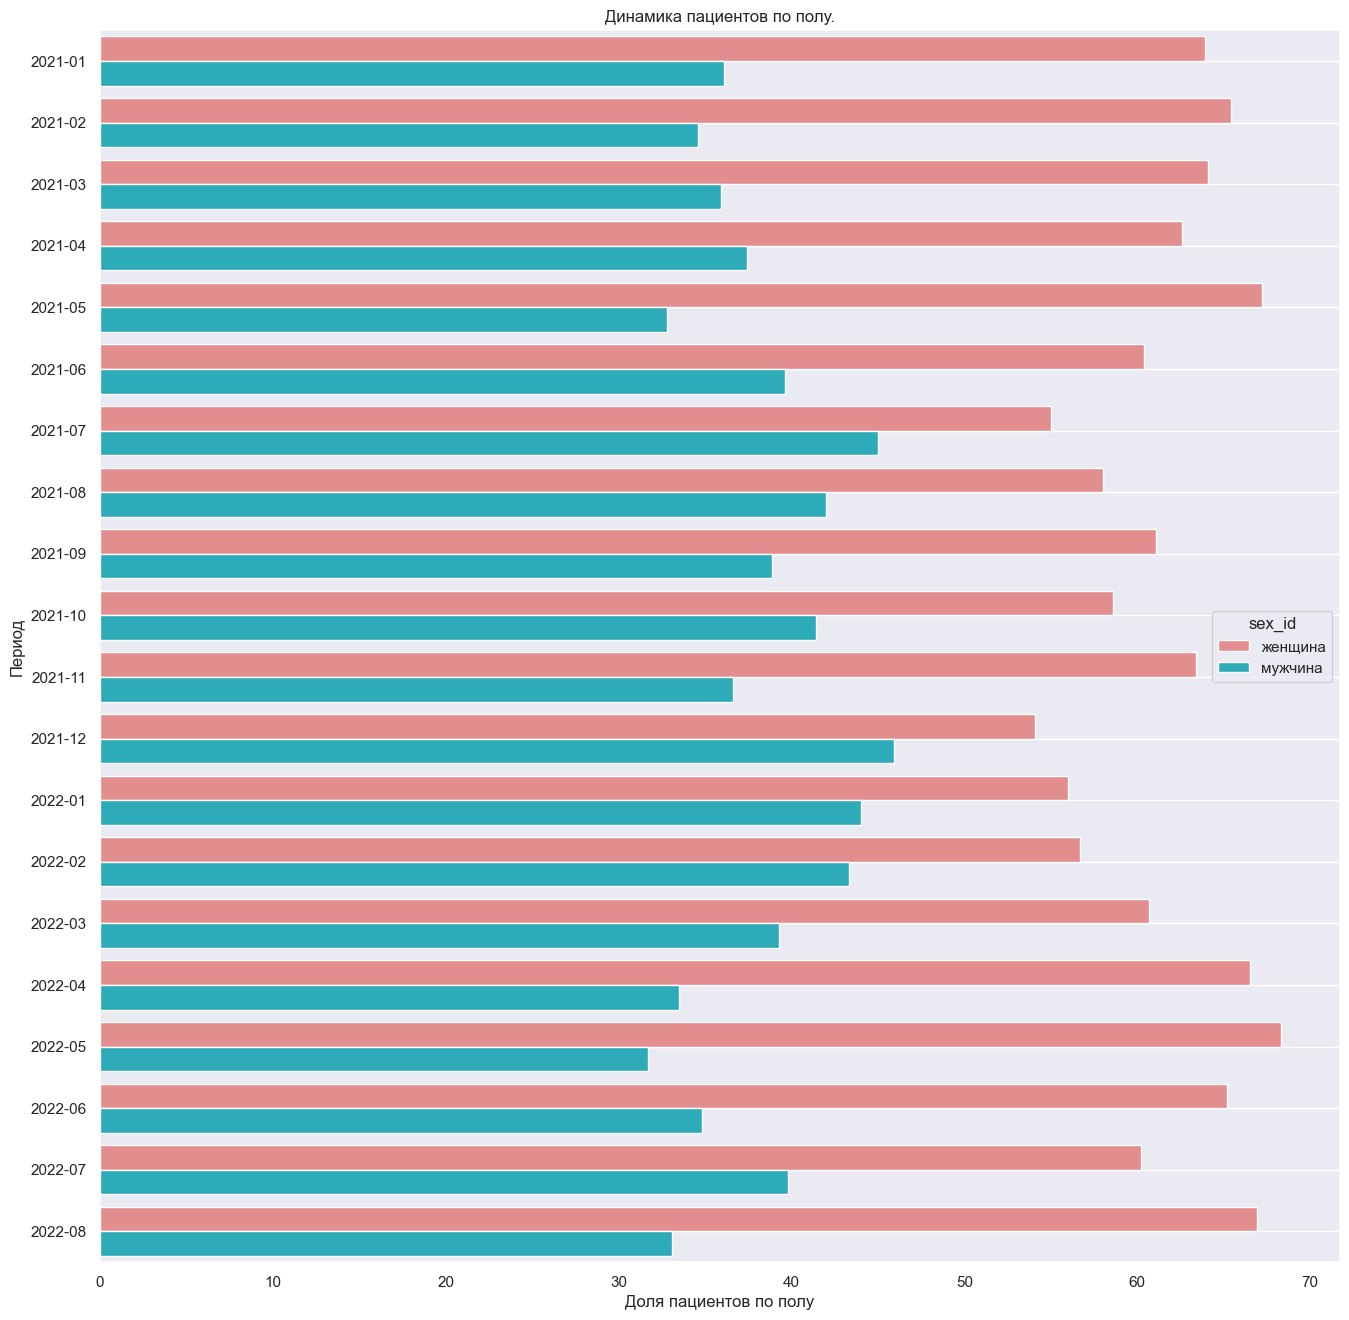

In [85]:
sns.set_style('dark')
sns.set_theme(rc={'figure.figsize':(16,16)})
sns.barplot(x='share_gender', y='service_period', data=gender_structure_fig, hue='sex_id', palette = ['lightcoral', '#17becf'])
plt.title('Динамика пациентов по полу.')
plt.xlabel('Доля пациентов по полу')
plt.ylabel('Период')
plt.legend
plt.grid()
plt.show();

В 2022г. наблюдаем уменьшение доли пациентов-мужчин, возврат к уровню 2021г.

**Выводы относительно влияния половозрастной структуры на снижение выручки в 2022г**:
* доля пациентов пациентов женского пола составляет 57%, мужчин - 43%. При этом женщины обращаются в клинику чаще, в 62% случаев. Существенного изменения доли полов не наблюдаем. Но отмечаем, что в 2022г. выросла доля пациентов женщин, а доля мужчин вернулась к уровню 2021г.
* для анализа групп пациентов по возрасту использовали следующую классификацию:
    * 0 - 17 - дети и подростки
    * 18 - 44 - молодой возраст
    * 45 - 59 - средний возраст
    * 60 - 74 - пожилой возраст
    * 75 и выше - старческий возраст (представители данной группы встречаются всего в 5 месяцах и их доля не превышает 0.5%).

Следует обратить внимание, что в августе 2022г резко упала доля пациентов в категории "дети и подростки" - если в мае-июле эта доля пациентов составляла порядка 7%, что сопоставим с данными 2021г, то в августе 2022г. была минимальной за весь период наблюдений (3.8%), а в августе 2021г наблюдался рост (8.2% относительно 5.2% в июле 2021г) - можно предположить, что в августе дети/подростки возвращаются к учебному году и требуется оформление справок и прохождение медосмотров. Анализ доли выручки по данной возрастной категории показывает, что здесь закономерности аналогичны доле числа клиентов - в августе 2021г доля в выручке составляла 7.6%, в августе 2022г - 3.3%. При этом в январе-июле 2022г доля детей и подростков в выручке стабильно была выше 5.5% (среднее - 7%). 
Однако можно обратить внимание на то, что при падении доли детей и подростков увеличилась доля клиентов среднего возраста, доля женщин, чек по которым (выручка деленная на число записей по клиенту (не уникальных клиентов) выше,чем по детям и подросткам. При этом на последнюю дату (данные за август 2022г) чеки в обеих возрастных группах показывают резкое падение. Отмечаем, что драйверами продаж являются молодые женщины.

На падение выручки динамика половозрастной структуры посетителей явного влияния не оказывает.

<a id="suggestion2"></a> 
### Влияние изменения структуры оказываемых услуг на выручку.

In [86]:
# проверим, есть ли отличия в изменениях показателей
# выручки и числа оказанных услуг в зависимости от принадлежности к той или иной категории услуг:
service_cat = data.pivot_table(index = ['service_period','category_service_name'], values = ['service_amount', \
                       'service_number'], aggfunc='sum').reset_index()
service_cat.columns = ['service_period','service_category', 'service_amount', 'service_number']
service_cat_add = service_cat.pivot_table(index = 'service_period', values = ['service_amount',\
                           'service_number'], aggfunc = 'sum').reset_index()
service_cat_add.columns = ['service_period', 'service_amount_total', 'service_number_total']
service_cat = service_cat.merge(service_cat_add, on = 'service_period', how = 'left')
service_cat['share_service_amount'] = round(service_cat['service_amount']/ \
                                                     service_cat['service_amount_total']*100,1)
service_cat['share_service_number'] = round(service_cat['service_number']/ \
                                                     service_cat['service_number_total']*100,1)
service_cat

,service_period,service_category,service_amount,service_number,service_amount_total,service_number_total,share_service_amount,share_service_number
0,2021-01,диагностика,538830,378,2163556,1999,24.90,18.90
1,2021-01,консультация,824717,583,2163556,1999,38.10,29.20
2,2021-01,лабораторная диагностика,351304,682,2163556,1999,16.20,34.10
3,2021-01,лечение,448705,356,2163556,1999,20.70,17.80
4,2021-02,диагностика,564053,377,2250655,2067,25.10,18.20
5,2021-02,консультация,927255,646,2250655,2067,41.20,31.30
6,2021-02,лабораторная диагностика,388746,734,2250655,2067,17.30,35.50
7,2021-02,лечение,370601,310,2250655,2067,16.50,15.00
8,2021-03,диагностика,969695,634,3723099,3626,26.00,17.50
9,2021-03,консультация,1411319,980,3723099,3626,37.90,27.00


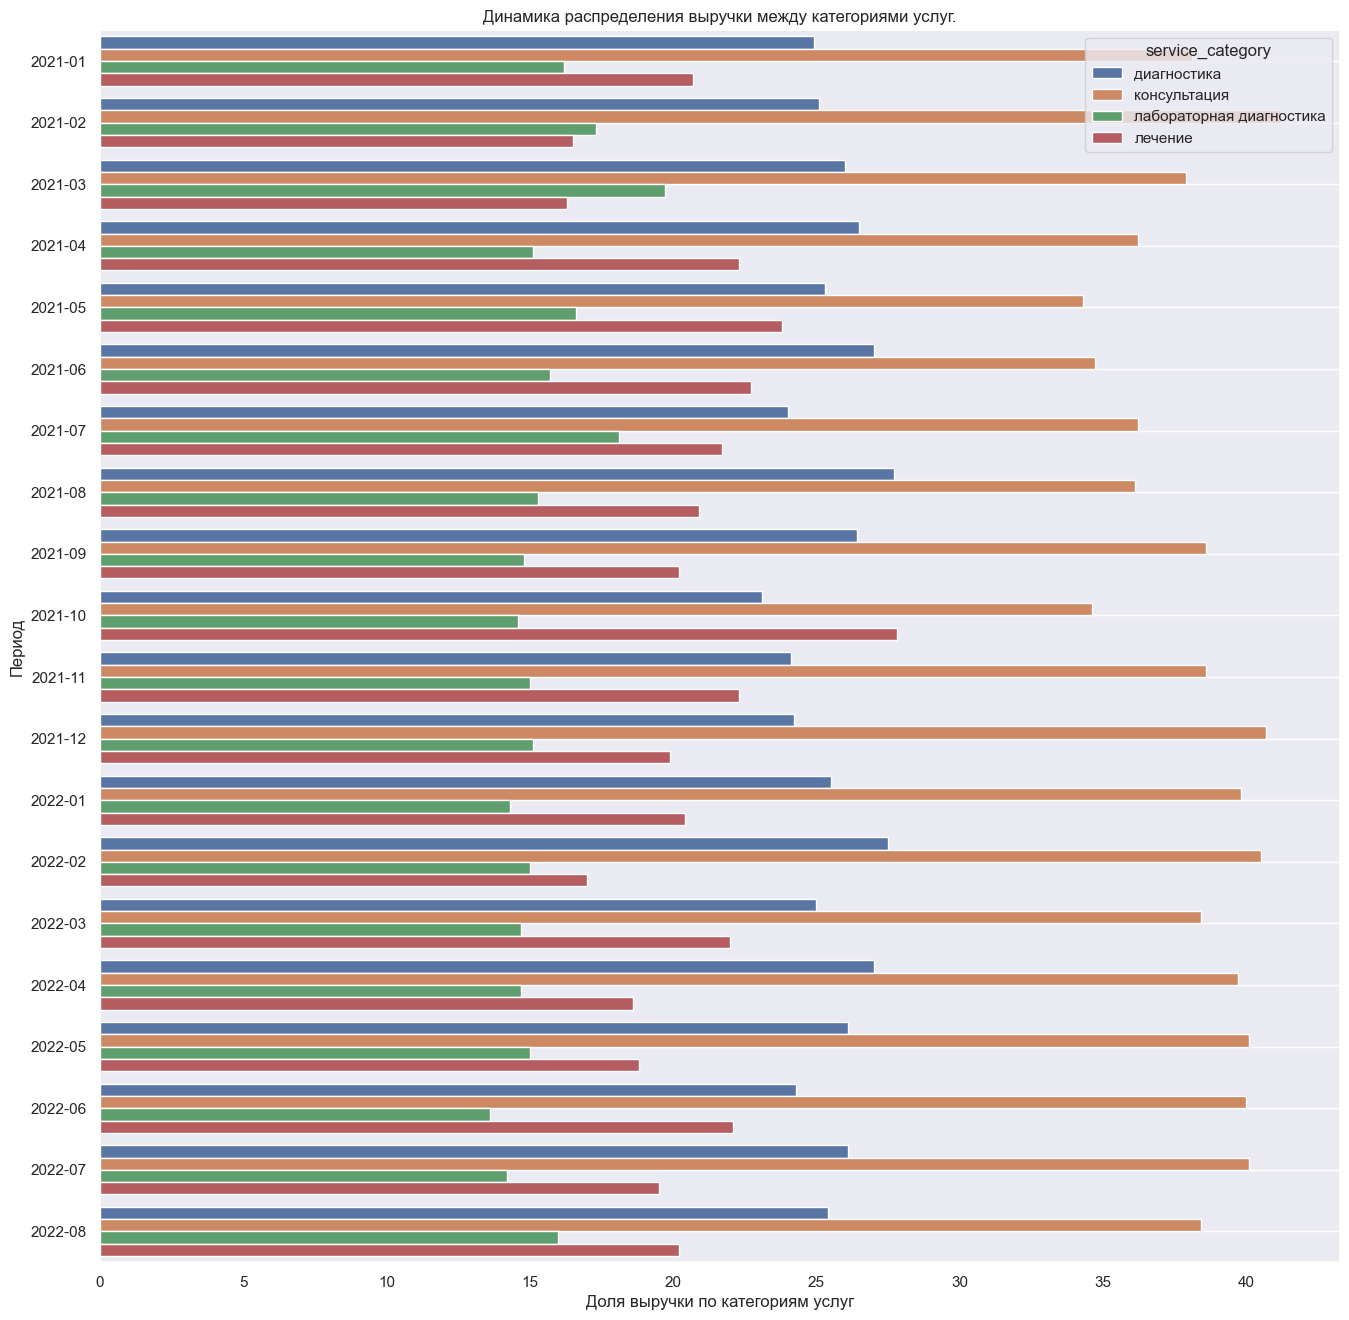

In [87]:
sns.set_style('dark')
sns.set_theme(rc={'figure.figsize':(16,16)})
sns.barplot(x='share_service_amount', y='service_period', data=service_cat, hue='service_category')
plt.title('Динамика распределения выручки между категориями услуг.')
plt.xlabel('Доля выручки по категориям услуг')
plt.ylabel('Период')
plt.legend
plt.grid()
plt.show();

В динамике времени не видно существенных изменений в распределении выручки по категориям услуг.

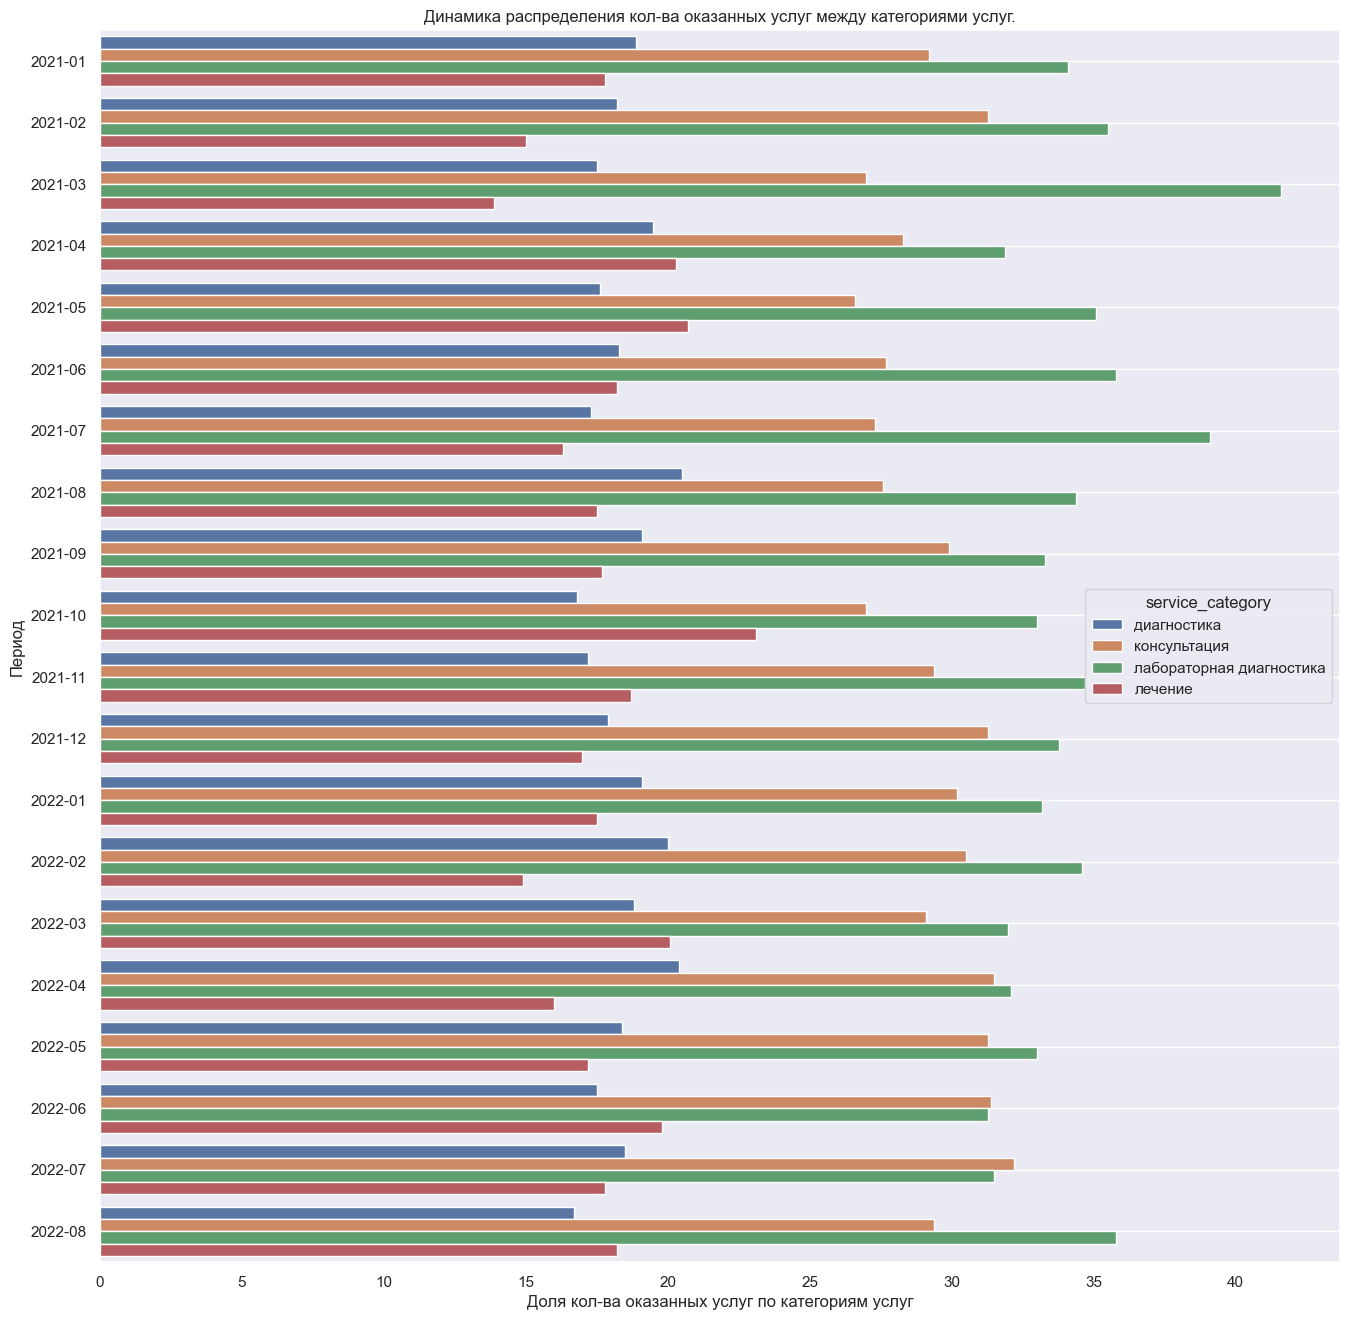

In [88]:
sns.set_style('dark')
sns.set_theme(rc={'figure.figsize':(16,16)})
sns.barplot(x='share_service_number', y='service_period', data=service_cat, hue='service_category')
plt.title('Динамика распределения кол-ва оказанных услуг между категориями услуг.')
plt.xlabel('Доля кол-ва оказанных услуг по категориям услуг')
plt.ylabel('Период')
plt.legend
plt.grid()
plt.show();

In [89]:
# посмотрим на ТОП-20 услуг по посещениям
serv=data.pivot_table(index='service_name', columns='service_period', values='record_id', aggfunc='count')
serv['all']=serv.sum(axis=1)
serv= serv.sort_values(by='all', ascending=False).head(20)
serv=serv.drop(columns='all')
print('Таблица количества оказанных услуг по месяцам, Топ-20 ')
serv

Таблица количества оказанных услуг по месяцам, Топ-20 


service_period,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08
service_name,,,,,,,,,,,,,,,,,,,,
первичный приём,320.00,326.00,542.00,549.00,521.00,541.00,523.00,568.00,669.00,720.00,707.00,743.00,784.00,857.00,946.00,1212.00,1121.00,1023.00,894.00,523.00
повторный приём,235.00,276.00,388.00,488.00,454.00,482.00,407.00,408.00,547.00,596.00,513.00,598.00,472.00,541.00,663.00,904.00,875.00,775.00,650.00,361.00
взятие крови из периферической вены,92.00,109.00,185.00,171.00,178.00,191.00,179.00,187.00,206.00,252.00,226.00,208.00,240.00,234.00,263.00,328.00,301.00,277.00,223.00,156.00
общий анализ крови лейкоцитарная форм соэ,74.00,90.00,146.00,138.00,132.00,128.00,139.00,147.00,168.00,198.00,162.00,149.00,204.00,174.00,185.00,233.00,232.00,199.00,169.00,121.00
магнитотерапия 1 сеанс,60.00,84.00,89.00,161.00,119.00,124.00,86.00,83.00,121.00,179.00,166.00,117.00,126.00,134.00,222.00,219.00,238.00,203.00,180.00,127.00
взятие мазка,41.00,30.00,41.00,60.00,53.00,53.00,62.00,53.00,62.00,72.00,62.00,76.00,121.00,96.00,107.00,115.00,137.00,120.00,104.00,94.00
общий анализ мочи,42.00,3.00,76.00,70.00,66.00,83.00,66.00,84.00,87.00,98.00,69.00,94.00,83.00,84.00,92.00,94.00,119.00,98.00,83.00,58.00
лазеротерапия 1 сеанс,2.00,20.00,62.00,85.00,54.00,39.00,32.00,50.00,60.00,101.00,68.00,84.00,62.00,80.00,93.00,93.00,89.00,102.00,65.00,72.00
интерференционные токи 1 сеанс 4 поля,26.00,25.00,49.00,77.00,67.00,66.00,26.00,30.00,46.00,94.00,65.00,39.00,30.00,57.00,119.00,69.00,90.00,71.00,92.00,57.00


Здесь видим увеличение количества услуг в октябре 2021г и апреле 2022г., судя по названиям услуг в эти периоды - возможные профосмотры.

**Выводы относительно влияния изменения структуры оказываемых услуг на снижение выручки в 2022г**:

Явного влияния изменений в структуре услуг на показатель выручки не выявлено - между категориями услуг выручка (как и количество услуг) распределяется достаточно единообразно. Как выяснили ранее изменились названия услуг, на созданных нами  категорях это не отразилось. Анализ ТОП-20 услуг по посещениям говорит об увеличении количества услуг. Судя по всплескам количества услуг, возможно, клиника проводит профосмотры. Но на снижение выручки в 2022г. изменение структуры оказываемых услуг влияния не оказывает.

<a id="suggestion3"></a> 
### Влияние ценообразования по услугам на выручку.

Проверим, не было ли падение выручки связано с ростом цен на услуги, что привело к оттоку клиентов: в рамках исследовательского анализа данных ([63]) мы строили помесячную таблицу основных показателей, в которой видно, что величина "выручка от оказания 1 услуги" (amt_per_service) достигла максимума в июле 2022г (1264,70 руб.), при этом прирост к аналогичному значению июля 2021г составил 20.3%. При этом в августе 2022г. на фоне падения общей выручки (service_amt) и числа клиентов (service_num), выручка на клиента достигла максимального значения (10352.3 руб.), что косвенно может подтверждать предположение о том, что цены на услуги были повышены, что привело к снижению клиентопотока и общей выручки. Кроме того, по таблице, выведенной в [69] средний чек резко возрастал MoM в октябре 2021г. на 12,9%, в июле 2022г. на 11%.
Для проверки возьмем топ-20 популярных услуг мая 2022  и оценим динамику цены одной услуги для мая-августа 2022г (для каждого месяца посчитаем выручку от оказания услуги и разделим на число оказанных услуг).

In [90]:
 # отбираем наименования ТОП-20 услуг по посещениям за май 2022:
top20_05_22 = data[(data['service_year'] == 2022) & (data['service_month'] == 5)].pivot_table \
                                    (index = 'service_name', values='record_id', aggfunc = 'count').\
                                    sort_values(by = 'record_id', ascending = False).reset_index()

lst_service = top20_05_22['service_name'].head(20).unique()
lst_service 

array(['первичный приём', 'повторный приём',
       'взятие крови из периферической вены', 'магнитотерапия 1 сеанс',
       'общий анализ крови лейкоцитарная форм соэ', 'взятие мазка',
       'общий анализ мочи', 'гинекологический мазок',
       'интерференционные токи 1 сеанс 4 поля', 'лазеротерапия 1 сеанс',
       'ультразвуковое исследование гинекология трансвагинально с дс сосудов',
       'интерпретация экг с описанием',
       'исследование соскобов  с поверхн шейки матки',
       'исследование соскобов  с поверхн цервикального канала',
       'снятие экг без интерпретации и описания', 'сеанс рефлексотерапии',
       'комплексная мануальная терапия', 'аст аспартатаминотрансфераза',
       'алт аланинаминотрансфераза',
       'классический лечебный массаж шейно-грудного отдела'], dtype=object)

In [91]:
#выведем информацию за нужные периоды по топ-20 услугам мая 2022:
data_price_dyn_2022 = data[(data['service_name'].isin(lst_service ))&(data['service_period'].\
        isin(['2022-05','2022-06','2022-07','2022-08']))].pivot_table(index = 'service_name', columns = 'service_period',\
        values = ['service_amount','service_number'], aggfunc = 'sum').reset_index()
data_price_dyn_2022.columns =['service_name','2022-05 amt','2022-06 amt','2022-07 amt','2022-08 amt',
                              '2022-05 service num','2022-06 service num','2022-07 service num','2022-08 service num']
for i in range(5,9):
    data_price_dyn_2022[f"2022-0{i} service price"] = round(data_price_dyn_2022[f"2022-0{i} amt"] \
                                                            /data_price_dyn_2022[f"2022-0{i} service num"],1)
data_price_dyn_2022    

,service_name,2022-05 amt,2022-06 amt,2022-07 amt,2022-08 amt,2022-05 service num,2022-06 service num,2022-07 service num,2022-08 service num,2022-05 service price,2022-06 service price,2022-07 service price,2022-08 service price
0,алт аланинаминотрансфераза,15950.00,13050.00,8700.00,8100.00,55.00,45.00,29.00,27.00,290.00,290.00,300.00,300.00
1,аст аспартатаминотрансфераза,13750.00,11250.00,7975.00,7425.00,55.00,45.00,29.00,27.00,250.00,250.00,275.00,275.00
2,взятие крови из периферической вены,51170.00,47090.00,42075.00,29546.00,301.00,277.00,225.00,158.00,170.00,170.00,187.00,187.00
3,взятие мазка,68400.00,56520.00,55044.00,46722.00,190.00,157.00,139.00,118.00,360.00,360.00,396.00,395.90
4,гинекологический мазок,57750.00,42900.00,42600.00,34200.00,105.00,78.00,71.00,57.00,550.00,550.00,600.00,600.00
5,интерпретация экг с описанием,32450.00,28050.00,29040.00,13915.00,59.00,51.00,48.00,23.00,550.00,550.00,605.00,605.00
6,интерференционные токи 1 сеанс 4 поля,98100.00,77390.00,103040.00,63840.00,90.00,71.00,92.00,57.00,1090.00,1090.00,1120.00,1120.00
7,исследование соскобов с поверхн цервикального канала,56260.00,44620.00,31000.00,30000.00,58.00,46.00,31.00,30.00,970.00,970.00,1000.00,1000.00
8,исследование соскобов с поверхн шейки матки,56260.00,39770.00,30000.00,31000.00,58.00,41.00,30.00,31.00,970.00,970.00,1000.00,1000.00
9,классический лечебный массаж шейно-грудного отдела,70400.00,56320.00,35640.00,22440.00,55.00,44.00,27.00,17.00,1280.00,1280.00,1320.00,1320.00


In [92]:
# видим, что в июле произошел рост цен на все ключевые услуги. Оценим этот рост в процентном отношении:
data_price_dyn_2022['2022-07 price_delta'] = round((data_price_dyn_2022['2022-07 service price'] \
                                                   /data_price_dyn_2022['2022-06 service price']-1)*100,2)
data_price_dyn_2022[['service_name','2022-07 price_delta']]

,service_name,2022-07 price_delta
0,алт аланинаминотрансфераза,3.45
1,аст аспартатаминотрансфераза,10.00
2,взятие крови из периферической вены,10.00
3,взятие мазка,10.00
4,гинекологический мазок,9.09
5,интерпретация экг с описанием,10.00
6,интерференционные токи 1 сеанс 4 поля,2.75
7,исследование соскобов с поверхн цервикального канала,3.09
8,исследование соскобов с поверхн шейки матки,3.09
9,классический лечебный массаж шейно-грудного отдела,3.12


In [93]:
# видим, что на многие услуги ценник действительно вырос на 10%. Для того, чтобы показать, что топ-20 услуг мая формировали
# не меньшую долю в выручке июня-августа, посчитаем доли в выручке для этих услуг:
data_total_amt = data.pivot_table(index = 'service_period', values = 'service_amount', aggfunc = 'sum').reset_index()
data_total_amt.columns = ['service_period','total_amount']
data_top20_amt = data[data['service_name'].isin(lst_service)].pivot_table(index = 'service_period',\
                     values = 'service_amount', aggfunc = 'sum').reset_index()
data_top20_amt = data_top20_amt.merge(data_total_amt, on = 'service_period', how = 'left')
data_top20_amt['lst service share'] = round(data_top20_amt['service_amount']/data_top20_amt['total_amount']*100,2)
data_top20_amt[data_top20_amt['service_period'].isin(['2022-05','2022-06','2022-07','2022-08'])]


,service_period,service_amount,total_amount,lst service share
16,2022-05,4510130,7586400,59.45
17,2022-06,4009650,6879580,58.28
18,2022-07,3554069,6214515,57.19
19,2022-08,2118698,3716459,57.01


In [94]:
# видим, что доля топ-20 услуг мая достаточно стабильна - 60-65%. Проверим по данным таблицы pivot_abs, которую получили на 
# шаге [33], что в других периодах не было столь крупных приростов цен относительно предыдущего месяца - сначала по общей 
# динамике показателя средняя цена услуги, без детализации по услугам:
pivot_abs_2 = tab[['service_year','service_month','amt_per_service']]
pivot_abs_2['amt_per_service_delta MoM, %'] = round(pivot_abs_2['amt_per_service'].pct_change()*100,1)
pivot_abs_2

,service_year,service_month,amt_per_service,"amt_per_service_delta MoM, %"
0,2021,1,1082.30,NaN
1,2021,2,1088.90,0.60
2,2021,3,1026.80,-5.70
3,2021,4,1089.00,6.10
4,2021,5,1085.40,-0.30
5,2021,6,1117.30,2.90
6,2021,7,1051.40,-5.90
7,2021,8,1095.00,4.10
8,2021,9,1087.30,-0.70
9,2021,10,1164.60,7.10


Видим, что рост, аналогичный наблюдавшемуся в июле 2022 происходил в апреле и октябре 2021г. Однако в апреле ему 
предшествовало падение на аналогичную величину в марте, те в апреле по сути произошла коррекция к исходным значениями
возможно, в марте в медцентре проходили акции для привлечения клиентов и цены были снижены. В октябре же произошел скачок,
который лишь частично скорректировался в ноябре. На графиках [34] видим, что для ноября 2021г было также характерно снижение
выручки и числа клиентов, которое скорректировалось в декабре. 

**Выводы относительно влияния изменения стоимости услуг на снижение выручки в 2022г**:

Удалось выявить фактор резкого падения выручки в период с мая по август 2022г. В июле 2022г. произошел рост стоимости услуг (проверено на примере топ-20 услуг, приносящих 60 - 65% выручки) от 3 до 10%. При анализе данных обнаружили, что подобный рост наблюдался в октябре 2021г. и также привел к некоторому снижению выручки в ноябре 2021г.

<a id="results"></a> 
## Общие выводы по кейсу.

Мы проанализировали данные о посещениях медицинского центра с января 2021г по август 2022г. Была доступна информация о визитах пациентов с указанием даты обращения, id клиента и его персональных данных (пол, возраст), наименование услуги, сумма оплаты и количество оказанных услуг.

При анализе данных было выявлено падение выручки начиная с мая 2022г, что не соответствовало динамике 2021г., более того, в августе падение стало стремительным и показатели выручки, кол-ва оказанных услуг и клиентов резко упали относительно аналогичного периода предыдущего года.

Для выявления причин подобной ситуации были проанализированы 3 возможных фактора::

* **Влияние половозрастного состава посетителей на изменение выручки** Версия не подтвердилась, структура клиентов по полу и возрасту достаточно стабильна.
* **Влияние изменения структуры оказываемых услуг на динамику выручки** Т.к. число наименований конкретных услуг превышает 400, анализ проводился по укрупненным группам услуг. Существенного изменения в их структуре не обнаружено. Динамика распределения количества оказанных услуг по категориям и динамика распределения выручки по категориям услуг без существенных изменений.
* **Влияние стоимости услуги на динамику выручки** В аналитике, построенной на этапе исследовательского анализа данных выявили, что стоимость оказания одной услуги (выручка, отнесенная к суммарному кол-ву оказанных услуг) в июле 2022г. выросла относительно июля 2021г. на 19.5%, что существенно выше наблюдений за другие периоды. Проанализировали топ-20 наиболее популярных услуг мая 2022г. (далее подтвердили, что их доля в выручке стабильна, т.е. эти услуги популярны и в другие периоды анализа и установили, что рост цен на услуги в июле составил от 3 до 10% (чаще более 5%). Рост цен сопровождался падением выручки в последующие периоды.

**Общий вывод**:
Среди рассмотренных факторов основную роль сыграло повышение цен, которое привело к уменьшению числа клиентов в следующем месяце и, как следствие, падению выручки. Для стабилизации ситуации, если медцентр не ожидает в текущем/ближайших периодах увеличения цен у конкурентов, можно предложить точечные корректировки прайса/проведение акций для восстановления клиентопотока.